# Sentiment Analysis

This notebook is the `first` part of the project.

#### Table of Contents
- [Data Preparation](#Data-Preparation)
  - [Loading Local Datasets](#Loading-Local-Datasets)
  - [Additional Setup](#Additional-Setup)
  - [Pre-processing](#Pre-processing)
- [*PyTorch* Model](#PyTorch-Model)
  - [Construct *BERT* Model](#Construct-BERT-Model)
  - [Model Helper Class *SentimentAnalyser*](#Model-Helper-Class-SentimentAnalyser)
  - [Fine-tuning *BERT* model](#Fine-tuning-BERT-model)
- [Ensemble Learning (*Bagging*)](#Ensemble-Learning-(Bagging))
  - [Train ensemble's models](#Train-ensemble's-models)
  - [Results Visualisation](#Results-Visualisation)
  - [*Ensemble* class](#Ensemble-class)
  - [Predictions using Ensemble Model](#Predictions-using-Ensemble-Model)

### Set up environment

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import time
import re
import json
import mlnotify # Notifer for ML training
from tqdm import tqdm
import numpy as np
import contractions
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from datasets import load_dataset, DatasetDict, Dataset
import evaluate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'''Device \x1b[{"94" if str(device) == "cuda" else "32"}m"{device}"\x1b[0m is available!
Device Name: \x1b[94m"{torch.cuda.get_device_name()}"\x1b[0m''')
!nvidia-smi

Device "cuda" is available!
Device Name: "Tesla V100-PCIE-32GB"
Sat Mar 25 13:06:17 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB            Off| 00000000:18:00.0 Off |                    0 |
| N/A   38C    P0               40W / 250W|      4MiB / 32768MiB |      3%      Default |
|                                         |                      |                  N/A |
+---

## Data Preparation

### Loading Local Datasets

In [2]:
# Specify the path of data repository / data file
# dataset_path = "../data/golden/*"
# dataset_path = "../data/trail_#6000.json"
dataset_path = "../data/labelled/trail_labelled_230227_#63481.json"

# Load dataset (Shuffle and Flatten)
dataset = load_dataset("json", data_files=dataset_path, split="train").shuffle(seed=42).flatten().select(range(2000))
# Explanation: flatten() makes {sentiment: {human: 0}} become {sentiment.human: 0}

# Name of The label used for training (Set to "sentiment.openai" if want to use chatGPT's label)
label_name = "sentiment.human"
dataset = dataset.map(lambda row: {"labels": row[label_name]}, batched=True)

# Split into train, valid and test data -> 80% : 10% : 10%
train_validtest_dataset = dataset.train_test_split(train_size=0.8, seed=42) # Shuffled by default
valid_test_dataset = train_validtest_dataset["test"].train_test_split(train_size=0.5, seed=42) # Shuffled by default
# Shuffle will make speed become 10x slower (Source: https://huggingface.co/docs/datasets/process#shuffle)

split_dataset = DatasetDict({  
    'train': train_validtest_dataset['train'],
    'validation': valid_test_dataset['train'],
    'test': valid_test_dataset['test']})

Found cached dataset json (/local/home/p11333at/.cache/huggingface/datasets/json/default-956d18ab677a1f0c/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)
Loading cached shuffled indices for dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-956d18ab677a1f0c/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-97fa5a204d97b031.arrow
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-956d18ab677a1f0c/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-aff26f1133bc436a.arrow
Loading cached split indices for dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-956d18ab677a1f0c/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-f5314ab91e2578c1.arrow and /local/home/p11333at/.cache/huggingface/datasets/json/default-956d18ab677a1f0c/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cach

#### Plot the distribution of labels

TOTAL number of data : 2000
Number of TRAIN data : 1600
Number of VALID data : 200
Number of TEST  data : 200


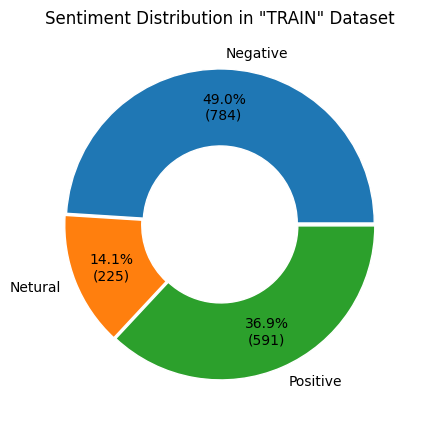

In [3]:
print(f"TOTAL number of data : {len(dataset)}")
print(f"Number of TRAIN data : {len(split_dataset['train'])}")
print(f"Number of VALID data : {len(split_dataset['validation'])}")
print(f"Number of TEST  data : {len(split_dataset['test'])}")

# Calculate sentiment distribution in TRAIN data
train_labels = torch.tensor(split_dataset['train']["labels"])
train_labels_distribution = [
    float(torch.count_nonzero(train_labels == 0)),
    float(torch.count_nonzero(train_labels == 1)),
    float(torch.count_nonzero(train_labels == 2)),
]

def func(pct, allvals):
    # (Source: https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html)
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

# Let's visualize the sentiments
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(train_labels_distribution, 
        labels=["Negative", "Netural", "Positive"], 
        explode=[.01, .01, .01],
        autopct=lambda pct: func(pct, train_labels_distribution),
        pctdistance=0.75,
        # labeldistance=.5,
        wedgeprops=dict(width=0.5, edgecolor='w'),
        textprops=dict(color="k"),)
ax.set_title("Sentiment Distribution in \"TRAIN\" Dataset")

plt.show()

### Additional Setup

In [4]:
# Initialise 'contractions' module
slang_path = "../data/slang.json"
with open(slang_path, "r") as f:
    slang_dicts = json.load(f)
    for slang in slang_dicts:
        # Add slang dictionaries to 'contractions' module
        contractions.add(slang, slang_dicts[slang])


# Choose BERT model from HuggingFace
model_name = "distilbert-base-uncased"

# Intantiate tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

### Pre-processing


In [5]:
# Define preprocessing functions

def preprocess_data(row):
    # Remove Aliases of Usernames and URLs in tweets
    pattern_name = r"\n+|(USERNAME_\d*\s*)"
    row["content"] = re.sub(pattern_name, "", row["content"])
    pattern_url = r"URL_\d*"
    row["content"] = re.sub(pattern_url, "URL ", row["content"]) # Add space after "URL" to prevent URL from being concatenated with other words
    # Expand contractions to full form
    row["content"] = contractions.fix(row["content"])
    return row

def tokenization(row):
    return tokenizer(
        row["content"], truncation=True, padding="max_length", max_length=100, return_tensors="pt"
    )

def one_hot_label(row):
    labels = torch.tensor(row["labels"])
    row["labels"] = torch.nn.functional\
        .one_hot(labels, num_classes=3)\
        .type(torch.FloatTensor)
    return row


tokenized_dataset = dataset.map(preprocess_data).map(tokenization, batched=True).map(one_hot_label, batched=True)
tokenized_dataset.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"]
)

#### Uncomment below lines if NOT using k-fold cross validation
# tokenized_dataset = split_dataset.map(preprocess_data).map(tokenization, batched=True)
# tokenized_dataset.set_format(
#     type="torch", columns=["input_ids", "attention_mask", "labels"]
# )

Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-956d18ab677a1f0c/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-861e81f5a9775832.arrow
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-956d18ab677a1f0c/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-d284edea8fb8f424.arrow
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-956d18ab677a1f0c/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-525277078963f7ba.arrow


#### Experiment: Find the most appropriate max_length for padding of tokenizer

[nltk_data] Downloading package punkt to
[nltk_data]     /local/home/p11333at/.cache...
[nltk_data]   Package punkt is already up-to-date!
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-956d18ab677a1f0c/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-a1078da6f96d6cb6.arrow
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-956d18ab677a1f0c/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-7fc5e1e6b427f9bf.arrow
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-956d18ab677a1f0c/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-838bc88a49033595.arrow


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-956d18ab677a1f0c/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-51f61a29be70e4d7.arrow
Loading cached processed dataset at /local/home/p11333at/.cache/huggingface/datasets/json/default-956d18ab677a1f0c/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-e356a37eb21e9750.arrow


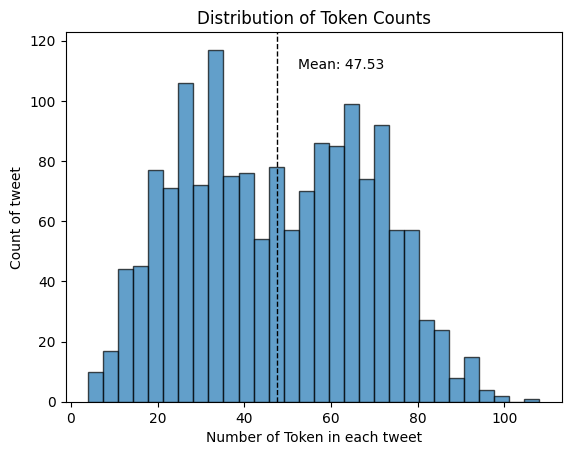

According to the graph,
Padding length '100' can include nearly all tweets
Padding length '80' can cover a fairly large proportion of tweets

Average word length  : 34.93
Average token length : 47.53


In [6]:
# Calculate average word length in original tweets (w/o Usernames and URLs)
word_length = evaluate.load("word_length", module_type="measurement")
average_word_length = word_length.compute(data=split_dataset["train"]["content"])

# Calculate the length of tokens in tokenized tweets
# (to help determine the max_length for padding)
trial_dataset = split_dataset.map(preprocess_data).map(
    lambda row: tokenizer(row["content"]), 
    batched=True
)

input_token_length = np.array(
    [len(input_ids) for input_ids in trial_dataset['train']["input_ids"]], 
    # dtype=torch.float
)

plt.hist(input_token_length, bins=30, edgecolor='k', alpha=0.7)
plt.gca().set(
    title='Distribution of Token Counts', 
    xlabel='Number of Token in each tweet', 
    ylabel='Count of tweet'
)
plt.axvline(
    input_token_length.mean(), 
    color='k', 
    linestyle='dashed', 
    linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(
    input_token_length.mean()*1.1, # The *1.1 here does position adjustment rather than math calculation
    max_ylim*0.9, 
    f'Mean: {input_token_length.mean():.2f}'
)
plt.show()

print("""According to the graph,
Padding length '100' can include nearly all tweets
Padding length '80' can cover a fairly large proportion of tweets""")

print(f"""
Average word length  : {average_word_length['average_word_length']:.2f}
Average token length : {input_token_length.mean():.2f}""")

## PyTorch Model

### Construct BERT Model

![Representation of layers of BERT model](http://www.mccormickml.com/assets/BERT/CLS_token_500x606.png)

In [7]:
class BertClassifier(nn.Module):
    """A BERT model with one extra sequential layer for classification task."""
    def __init__(self, bert_model_name, freeze_bert=False):
        super(BertClassifier, self).__init__()
        
        # Specify dimension for input, hidden, and output layers
        dim_in, dim_h, dim_out = 768, 128, 3

        # Instantiate BERT model
        self.bert_model = AutoModel.from_pretrained(bert_model_name)

        # Initialise a sequential feed-forward layer as classifier
        self.classifier = nn.Sequential(
            nn.Linear(dim_in, dim_h),
            nn.ReLU(),
            # nn.Dropout(0.1),
            nn.Linear(dim_h, dim_out)
        )

        if freeze_bert:
        # (1) True: We don't re-train the BERT model and train only the last layer
        # (2) False (Default): We train the complete BERT model
            for param in self.bert_model.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Feed input to BERT model to obtain contextualized representations
        bert_output = self.bert_model(input_ids, attention_mask)
        
        # On the output of final transformer layer,
        # only the first embedding (i.e. the [CLS] token) is used as the input to the classifier
        last_hidden_state_cls = bert_output.last_hidden_state[:, 0, :]
        
        # Feed input to classifier to obtain the logits
        logits = self.classifier(last_hidden_state_cls)
        
        return logits

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def create_dataloaders(dataset, batch_size):
    """Create dataloaders for train, validation, and test sets."""
    # irrelevant_columns = ['creation_date', 'content', 'sentiment.vader', 'sentiment.textblob']  # 'sentiment.openai'
    # (Add .remove_columns(irrelevant_columns) after dataset to remove irrelevant columns if needed)
        
    train_dataloader = DataLoader(dataset["train"], batch_size=batch_size)
    val_dataloader = DataLoader(dataset["validation"], batch_size=batch_size)
    test_dataloader = DataLoader(dataset["test"], batch_size=batch_size)
    
    dataloaders = {"train": train_dataloader,
                  "validation": val_dataloader,
                  "test": test_dataloader}
    
    return dataloaders

### Model Helper Class `SentimentAnalyser`

The `SentimentAnalyser` class contains the functions of model training, evaluating and predicting.

**Learning Sources**
1. [(Article) BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
2. [(Colab) Fine-tuning BERT for Sentiment Analysis](https://colab.research.google.com/drive/1f32gj5IYIyFipoINiC8P3DvKat-WWLUK#scrollTo=JkMK5VqJJvSO)

In [8]:
class SentimentAnalyser(object): 
    """This class is responsible for manipulating training and evaluating a model and making prediction."""
    def __init__(self, model, loss_fn, optimizer):

        # ---------- Define Attributes ----------
        # Store parameters as attributes 
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Send the model to the specified device
        self.model.to(self.device)

        # These attributes are not initialised at the moment of creation
        self.train_loader = None
        self.val_loader = None
        
        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.val_accuracies = []
        self.total_epochs = 0

        # Creates the train_step function for our model, 
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        """This method allows the user to choose a different device to train the model on"""
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        """This method defines train_loader and val_loader(optional)"""
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        """This method builds the function that performs a step in the train loop."""
        def perform_train_step_fn(input_ids, attention_mask, labels):
            # Sets model to TRAIN mode
            self.model.train()

            # Clears previous gradients from the last step
            self.optimizer.zero_grad()

            # Computes prediction and loss
            logits = self.model(input_ids, attention_mask)
            loss = self.loss_fn(logits, labels)
            
            # Backpropagation
            loss.backward()
            # Updates parameters using gradients and the learning rate
            self.optimizer.step()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn
    
    def _make_val_step_fn(self):
        """This method builds the function that performs a step in the validation loop."""
        def perform_val_step_fn(input_ids, attention_mask, labels):
            # Sets model to EVAL mode
            self.model.eval()

            # Computes prediction and loss
            with torch.no_grad():
                logits = self.model(input_ids, attention_mask)
                loss = self.loss_fn(logits, labels)

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the validation loop
        return perform_val_step_fn
            
    def _mini_batch(self, validation=False):
        """This method performs a mini-batch loop. 
        By default, it performs the train loop. Set `validation=True` to perform the validation loop."""
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None
            
        # Once the data loader and step function, this is the 
        # same mini-batch loop we had before
        mini_batch_losses = []
        
        # Iterates over the batches of the data loader
        for i, batch in enumerate(data_loader):
            
            # Unpacks the batch into components
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            # Computes loss for this batch
            mini_batch_loss = step_fn(input_ids, attention_mask, labels)
            mini_batch_losses.append(mini_batch_loss)

        # Computes the mean of the batch losses
        loss = np.mean(mini_batch_losses)
            
        return loss

    def set_seed(self, seed=42):
        """Set seed for reproducibility. All seeds are set to 42 by default."""
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False    
        torch.manual_seed(seed)
        np.random.seed(seed)

    
    def train(self, n_epochs, evaluation=True, evaluate_before_training=True, seed=42):
        """This method performs the training loop.
        By default, it evaluates the model after each epoch."""

        # To ensure reproducibility of the training process
        self.set_seed(seed)

        # Keeps track of the training process
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Evaluates the model before training
        if evaluate_before_training and evaluation:
            # Evaluating (Validation dataloader is used by default if no dataloader is specified)
            metrics = self.evaluate()
            
            # Unpack the metrics
            val_loss = metrics['val_loss']
            val_accuracy = metrics['val_accuracy']

            # Print performance
            print(f"{'0':^7} | {'-':^7} | {'-':^12.6} | {val_loss:^10.6f} | {val_accuracy:^9.3f} | {'-':^9.2}")
            print("-"*70)

        # Outer Loop
        for epoch in range(n_epochs):
            # ========================================
            # ==============  Training  ==============
            # ========================================
            
            # Set the model to training mode
            self.model.train()

            # Record start time of the epoch
            t0_epoch, t0_batch = time.time(), time.time()

            # Keep track of the number of epochs
            self.total_epochs += 1

            # Record the training loss for each batch
            mini_batch_losses = []
            
            # Inner Loop (Iterate over the batches of the data loader)
            for step, batch in enumerate(self.train_loader):
                
                # Unpack the batch into components
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                # Compute loss for this batch
                mini_batch_loss = self.train_step_fn(input_ids, attention_mask, labels)
                mini_batch_losses.append(mini_batch_loss)

                if ((step+1) % 20 == 0 and step != len(self.train_loader)-1):
                    # Calculate time elapsed for 20 batches
                    time_elapsed = time.time() - t0_batch

                    # Print training results
                    print(f"{epoch + 1:^7} | {step+1:^7} | {np.mean(mini_batch_losses):^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                    # Reset timer
                    t0_batch = time.time()

            # Compute the mean of the batch losses
            loss = np.mean(mini_batch_losses)

            # Keep track of the training loss
            self.losses.append(loss)

            # ========================================
            # =============  Evaluating  =============
            # ========================================
        
            # (Validation dataloader is used by default if no dataloader is specified)
            metrics = self.evaluate()

            # Unpack the metrics
            val_loss = metrics['val_loss']
            val_accuracy = metrics['val_accuracy']

            # Keep track of the validation loss and accuracy
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)

            if evaluation == True:
                # Calculate time spent for the epoch
                time_elapsed = time.time() - t0_epoch
                
                # Print performance
                print(f"{epoch + 1:^7} | {len(self.train_loader):^7} | {loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.3f} | {time_elapsed:^9.2f}")
                print("-"*70)



    def evaluate(self, dataloader=None):
        """This method evaluates the model on given dataloader.
        If dataloader is not specified, the validation dataloader is used by default."""
        # Evaluation mode (Dropout layers are disabled during the evaluation phase)
        self.model.eval()

        # Tracking variables
        all_labels = []
        all_logits = []
        mini_batch_losses = []

        # Set dataloader
        if dataloader:
            val_dataloader = dataloader
        else:
            val_dataloader = self.val_loader

        for batch in val_dataloader:
            # Unpack the batch into components
            input_ids=batch['input_ids'].to(device)
            attention_mask=batch['attention_mask'].to(device)
            labels=batch['labels'].to(device)
            
            # Compute logits and loss for this batch
            with torch.no_grad():
                logits = self.model(input_ids, attention_mask)
                loss = self.loss_fn(logits, labels)
            
            mini_batch_losses.append(loss.item())

            all_labels.append(labels)#.cpu().numpy().tolist())
            all_logits.append(logits)#.cpu().numpy().tolist())


        # Computes the mean of the batch losses
        val_loss = np.mean(mini_batch_losses)

        # Concatenate all logits and labels
        all_logits = torch.cat(all_logits, dim=0).to(device)
        all_labels = torch.cat(all_labels, dim=0).to(device)

        # Get the predictions
        val_preds = torch.argmax(all_logits, dim=1).flatten()
        val_labels = torch.argmax(all_labels, dim=1).flatten()
        # Calculate the accuracy rate
        val_accuracy = accuracy_score(val_labels.cpu().numpy(), val_preds.cpu().numpy())  #####

        return {"val_loss": val_loss, "val_accuracy": val_accuracy}

    def save_checkpoint(self, filename):
        """This method saves the model state, optimizer state, and other parameters to a checkpoint file."""
        # Builds dictionary with all elements for checkpoint
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses,
                      'val_accuracy': self.val_accuracies}

        # Saves dictionary to file
        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        """This method loads the model state, optimizer state, and other parameters from a checkpoint file."""
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        # Restore other state
        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']
        self.val_accuracies = checkpoint['val_accuracy']

        # Send model to device
        self.model.to(self.device)
        
        # Always set model to training mode for resuming training
        self.model.train()
    
    def predict(self, test_dataloader, return_logits=False):
        """This method predicts the labels for the test dataset."""
        # Evaluation mode (Dropout layers are disabled during the test time)
        self.model.eval()

        all_logits = []

        for batch in test_dataloader:
            input_ids=batch['input_ids'].to(device)
            attention_mask=batch['attention_mask'].to(device)
            # labels=batch['labels']

            with torch.no_grad():
                logits = self.model(input_ids, attention_mask)
            all_logits.append(logits)
        
        # Concatenate logits from each batch
        all_logits = torch.cat(all_logits, dim=0)
        if return_logits:
            return all_logits.detach().cpu().numpy()
        # Apply softmax to calculate probabilities
        probs = F.softmax(all_logits, dim=1).cpu().numpy()
        return probs

    def plot_losses(self):
        """This method plots the training and validation losses."""
        plt.style.use('seaborn-v0_8-paper')
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig


### Fine-tuning BERT model

    Authors recommendations for the purposes of fine-tuning
    - Batch size: 16, 32
    - Learning rate (Adam): 5e-5, 3e-5, 2e-5
    - Number of epochs: 2, 3, 4

Reference: Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)

In [38]:
# ====================== Hyperparameters ======================
set_seed(42)           # Set seed for reproducibility
epochs      = 3        # Recommends 2, 3, 4
lr          = 5e-5     # Recommends 5e-5, 3e-5, 2e-5 (for Adam)
batch_size  = 32       # Recommends 16, 32
# =============================================================
freeze_bert = False    # Set 'True' if only training the last layer
k_fold      = 5        # Number of folds for Stratified K Fold
checkpoint_path = "/local/home/p11333at/nlp-project/checkpoints/"
# =============================================================


In [49]:
import pandas as pd

/tmp/ipykernel_258709/559309707.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  param_results.append({'batch': batch_size, 'lr': str(lr), 'epochs': epochs, 'accuracy': 0.0}, ignore_index=True)


,batch,lr,epochs,accuracy
0,32,5e-05,3,0.0
1,32,5e-05,3,0.0
2,32,5e-05,3,0.0


#### Training starts here :-)

In [75]:
mlnotify.start()

import pandas as pd
import itertools
e = [2, 3, 4]
l = [2e-5, 3e-5, 5e-5]
b = [16, 32]

param_pairs = list(itertools.product(e, l, b))

param_results = pd.DataFrame(columns=['batch', 'lr', 'epochs', 'accuracy', 'elapsed'])

for epochs, lr, batch_size in param_pairs:
    # Record time
    start_time = time.time()

# ----------------------------

    # Stratified K Fold: each set contains approximately the same percentage of samples of each target class as the complete set.
    skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)

    # Keep track of the validation accuracy for each fold
    model_valid_accuracies = []

    # Loop for each fold
    for fold, (train_idx, valid_idx) in enumerate(skf.split(tokenized_dataset, tokenized_dataset[label_name])):
        if fold == 0:
            continue
        print(f"\033[1;37;42m    ==========  {fold+1}/{k_fold} Fold  ==========    \033[0m")
        
        # Split dataset & Create the DataLoader
        train_dataloader = DataLoader(tokenized_dataset.select(train_idx), batch_size=batch_size)
        valid_dataloader = DataLoader(tokenized_dataset.select(valid_idx), batch_size=batch_size)
        
        # Instantiate the Model
        model = BertClassifier(model_name, freeze_bert=freeze_bert)
        model.to(device)
        
        # Define an optimizer to update the parameters
        optimizer = optim.AdamW(
            model.parameters(),
            lr=lr,      # Default learning rate 5e-5
            eps=1e-8    # Default epsilon value 1e-8
        )
        # Define a loss function
        loss_fn = nn.BCEWithLogitsLoss()

        # Set up the learning rate scheduler
        num_training_steps = len(train_dataloader) * epochs
        scheduler = get_linear_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=0, # Default value
                                                    num_training_steps=num_training_steps)
        
        # Instantiate the SentimentAnalyser
        sa = SentimentAnalyser(model, loss_fn, optimizer)
        sa.set_loaders(train_dataloader, valid_dataloader)
        
        # Start training :-)
        sa.train(epochs)
        
        # Evaluate the model on the validation set & Append the result to the list
        model_valid_accuracies.append(sa.evaluate(valid_dataloader)['val_accuracy'])

        # Save the model checkpoint
        checkpoint_name = f"bert_classifier_{fold+1}.pt"
        sa.save_checkpoint(checkpoint_path+checkpoint_name)

        # Plot the training and validation losses
        # sa.plot_losses()
        
        # Relsase GPU memory
        del train_dataloader, valid_dataloader, model, optimizer, loss_fn, scheduler
        del sa.model, sa.optimizer, sa.loss_fn, sa.train_loader, sa.val_loader, sa
        torch.cuda.empty_cache()

        #######
        # break##
        #######

# ------------------------------------------------
    param_results = param_results.append({
        'batch': batch_size,
        'lr': str(lr), 
        'epochs': epochs, 
        'accuracy': f"{np.mean(model_valid_accuracies):.4f}",
        'elapsed': f"{(time.time()-start_time):.0f}s"}, ignore_index=True)

mlnotify.end()

                                     
                                     
    █▀▀▀▀▀█ ▀▀   █  ▄▄▀▀▀ █▀▀▀▀▀█    
    █ ███ █ █▄ █▀█▀█ ▄██  █ ███ █    
    █ ▀▀▀ █ ▀█▀▀▄█ ▀█▄▄█  █ ▀▀▀ █    
    ▀▀▀▀▀▀▀ ▀▄▀▄▀ █▄█▄▀▄█ ▀▀▀▀▀▀▀    
    █▀█▀ ▄▀▄█▄    ▄▀█▀███▀▄▄█▀▀ █    
    ▄▀ █▀ ▀▀▄  ▄▄█▄ █ ▄ ▄▀▄▄█ ▀▀▄    
     █ █  ▀ ▄▀▄█ ▀ ▄▄▀ █  ▄  ▀█▄▄    
    █ █▄▀▄▀▀ ▀▄ █ █ █▀▀▀   ▄▀ ▀█▀    
        █ ▀▀▄ ▄▀▄▀██ ▄▀ ▄▀ █▀█▄█     
    ▀ ▄▄▄ ▀ ██▄▀█  ▀▀▄▄ █ ▄ █ █      
     ▀▀ ▀ ▀ █▄█▀█ ▄▀██▄▀█▀▀▀███▄▄    
    █▀▀▀▀▀█  ▄ ▀▀██ █ █▀█ ▀ ██ █     
    █ ███ █ ▄▀▄▄█▀ █▄█▄ ▀█▀██▄▀▀█    
    █ ▀▀▀ █ ██ █ ▀▀ ▀ █ ██▄█▄▄▀▄▀    
    ▀▀▀▀▀▀▀ ▀ ▀   ▀ ▀ ▀ ▀▀  ▀  ▀     
                                     
                                     
https://mlnotify.aporia.com/training/877934

Scan the QR code or enter the url to get a notification when your training is done


    ==========  2/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693229  |   0.135   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.636751   |     -      |     -     |   2.08   
   1    |   40    |   0.604065   |     -      |     -     |   2.17   
   1    |   60    |   0.595176   |     -      |     -     |   2.18   
   1    |   80    |   0.584947   |     -      |     -     |   2.19   
   1    |   100   |   0.576716   |  0.526423  |   0.535   |   11.41  
----------------------------------------------------------------------
   2    |   20    |   0.532800   |     -      |     -     |   1.90   
   2    |   40    |   0.516009   |     -      |     -     |   1.97   
   2    |   60    |   0.502215   |     -      |     -     |   1.98   
   2    |   80    |   0.492952   |     -      |     -     |   1.97   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.689031  |   0.345   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.634176   |     -      |     -     |   2.08   
   1    |   40    |   0.603714   |     -      |     -     |   2.06   
   1    |   60    |   0.594450   |     -      |     -     |   2.09   
   1    |   80    |   0.582929   |     -      |     -     |   2.10   
   1    |   100   |   0.575997   |  0.528293  |   0.530   |   11.02  
----------------------------------------------------------------------
   2    |   20    |   0.522204   |     -      |     -     |   2.19   
   2    |   40    |   0.506028   |     -      |     -     |   2.18   
   2    |   60    |   0.489117   |     -      |     -     |   2.14   
   2    |   80    |   0.473800   |     -      |     -     |   2.19   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.687848  |   0.403   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.639858   |     -      |     -     |   2.20   
   1    |   40    |   0.605308   |     -      |     -     |   2.11   
   1    |   60    |   0.592236   |     -      |     -     |   1.94   
   1    |   80    |   0.586028   |     -      |     -     |   2.04   
   1    |   100   |   0.578251   |  0.528686  |   0.570   |   11.05  
----------------------------------------------------------------------
   2    |   20    |   0.522595   |     -      |     -     |   2.15   
   2    |   40    |   0.495978   |     -      |     -     |   2.10   
   2    |   60    |   0.482655   |     -      |     -     |   2.18   
   2    |   80    |   0.473924   |     -      |     -     |   2.15   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.688692  |   0.375   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.637987   |     -      |     -     |   2.19   
   1    |   40    |   0.605524   |     -      |     -     |   2.13   
   1    |   60    |   0.590064   |     -      |     -     |   2.18   
   1    |   80    |   0.581789   |     -      |     -     |   2.12   
   1    |   100   |   0.572878   |  0.527522  |   0.573   |   11.27  
----------------------------------------------------------------------
   2    |   20    |   0.521325   |     -      |     -     |   2.12   
   2    |   40    |   0.492585   |     -      |     -     |   2.10   
   2    |   60    |   0.468153   |     -      |     -     |   2.17   
   2    |   80    |   0.461022   |     -      |     -     |   2.17   
   2    |   100  

/tmp/ipykernel_258709/2322675432.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  param_results = param_results.append({


    ==========  2/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.688604  |   0.372   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.623187   |     -      |     -     |   2.82   
   1    |   40    |   0.600214   |     -      |     -     |   2.82   
   1    |   50    |   0.593509   |  0.559630  |   0.482   |   7.54   
----------------------------------------------------------------------
   2    |   20    |   0.545972   |     -      |     -     |   2.81   
   2    |   40    |   0.530686   |     -      |     -     |   2.82   
   2    |   50    |   0.519978   |  0.496855  |   0.627   |   7.54   
----------------------------------------------------------------------
    ==========  3/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.688963  |   0.345   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.622872   |     -      |     -     |   2.85   
   1    |   40    |   0.599018   |     -      |     -     |   2.83   
   1    |   50    |   0.593772   |  0.562184  |   0.490   |   7.62   
----------------------------------------------------------------------
   2    |   20    |   0.547355   |     -      |     -     |   2.83   
   2    |   40    |   0.531352   |     -      |     -     |   2.83   
   2    |   50    |   0.520187   |  0.478176  |   0.665   |   7.58   
----------------------------------------------------------------------
    ==========  4/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.687747  |   0.403   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.625085   |     -      |     -     |   2.86   
   1    |   40    |   0.601004   |     -      |     -     |   2.84   
   1    |   50    |   0.594088   |  0.559101  |   0.492   |   7.61   
----------------------------------------------------------------------
   2    |   20    |   0.535959   |     -      |     -     |   2.83   
   2    |   40    |   0.525799   |     -      |     -     |   2.82   
   2    |   50    |   0.516139   |  0.488125  |   0.640   |   7.56   
----------------------------------------------------------------------
    ==========  5/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.688713  |   0.375   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.626204   |     -      |     -     |   2.85   
   1    |   40    |   0.599162   |     -      |     -     |   2.84   
   1    |   50    |   0.593152   |  0.558734  |   0.490   |   7.62   
----------------------------------------------------------------------
   2    |   20    |   0.544334   |     -      |     -     |   2.83   
   2    |   40    |   0.522927   |     -      |     -     |   2.83   
   2    |   50    |   0.510858   |  0.481623  |   0.660   |   7.57   
----------------------------------------------------------------------


/tmp/ipykernel_258709/2322675432.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  param_results = param_results.append({


    ==========  2/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.688670  |   0.372   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.622088   |     -      |     -     |   2.14   
   1    |   40    |   0.592529   |     -      |     -     |   2.04   
   1    |   60    |   0.583562   |     -      |     -     |   2.03   
   1    |   80    |   0.573884   |     -      |     -     |   2.08   
   1    |   100   |   0.560609   |  0.482477  |   0.670   |   11.01  
----------------------------------------------------------------------
   2    |   20    |   0.494558   |     -      |     -     |   1.91   
   2    |   40    |   0.471395   |     -      |     -     |   1.92   
   2    |   60    |   0.449546   |     -      |     -     |   1.92   
   2    |   80    |   0.439151   |     -      |     -     |   1.98   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.689031  |   0.345   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.622452   |     -      |     -     |   2.07   
   1    |   40    |   0.595689   |     -      |     -     |   2.06   
   1    |   60    |   0.586864   |     -      |     -     |   2.06   
   1    |   80    |   0.575613   |     -      |     -     |   2.08   
   1    |   100   |   0.565394   |  0.493190  |   0.650   |   11.06  
----------------------------------------------------------------------
   2    |   20    |   0.485605   |     -      |     -     |   2.07   
   2    |   40    |   0.465628   |     -      |     -     |   2.06   
   2    |   60    |   0.450715   |     -      |     -     |   2.06   
   2    |   80    |   0.434495   |     -      |     -     |   2.05   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.687848  |   0.403   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.627128   |     -      |     -     |   2.05   
   1    |   40    |   0.596889   |     -      |     -     |   2.06   
   1    |   60    |   0.584359   |     -      |     -     |   2.07   
   1    |   80    |   0.579117   |     -      |     -     |   2.04   
   1    |   100   |   0.568190   |  0.496192  |   0.635   |   10.93  
----------------------------------------------------------------------
   2    |   20    |   0.500043   |     -      |     -     |   2.05   
   2    |   40    |   0.471136   |     -      |     -     |   2.08   
   2    |   60    |   0.455049   |     -      |     -     |   2.04   
   2    |   80    |   0.444062   |     -      |     -     |   2.07   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.688692  |   0.375   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.628346   |     -      |     -     |   2.06   
   1    |   40    |   0.598781   |     -      |     -     |   2.03   
   1    |   60    |   0.580872   |     -      |     -     |   2.02   
   1    |   80    |   0.572223   |     -      |     -     |   2.00   
   1    |   100   |   0.563962   |  0.516343  |   0.598   |   10.84  
----------------------------------------------------------------------
   2    |   20    |   0.505812   |     -      |     -     |   2.03   
   2    |   40    |   0.477718   |     -      |     -     |   2.05   
   2    |   60    |   0.453833   |     -      |     -     |   2.05   
   2    |   80    |   0.444173   |     -      |     -     |   2.06   
   2    |   100  

/tmp/ipykernel_258709/2322675432.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  param_results = param_results.append({


    ==========  2/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.688604  |   0.372   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.609474   |     -      |     -     |   2.84   
   1    |   40    |   0.590311   |     -      |     -     |   2.84   
   1    |   50    |   0.583898   |  0.542081  |   0.505   |   7.60   
----------------------------------------------------------------------
   2    |   20    |   0.526194   |     -      |     -     |   2.79   
   2    |   40    |   0.500367   |     -      |     -     |   2.80   
   2    |   50    |   0.483565   |  0.439760  |   0.690   |   7.51   
----------------------------------------------------------------------
    ==========  3/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.688963  |   0.345   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.610160   |     -      |     -     |   2.86   
   1    |   40    |   0.588564   |     -      |     -     |   2.83   
   1    |   50    |   0.583737   |  0.548087  |   0.520   |   7.60   
----------------------------------------------------------------------
   2    |   20    |   0.532188   |     -      |     -     |   2.81   
   2    |   40    |   0.502888   |     -      |     -     |   2.82   
   2    |   50    |   0.485094   |  0.438910  |   0.705   |   7.56   
----------------------------------------------------------------------
    ==========  4/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.687747  |   0.403   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.612053   |     -      |     -     |   2.84   
   1    |   40    |   0.591406   |     -      |     -     |   2.82   
   1    |   50    |   0.584387   |  0.541724  |   0.497   |   7.58   
----------------------------------------------------------------------
   2    |   20    |   0.512360   |     -      |     -     |   2.82   
   2    |   40    |   0.496242   |     -      |     -     |   2.83   
   2    |   50    |   0.480299   |  0.444963  |   0.703   |   7.56   
----------------------------------------------------------------------
    ==========  5/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.688713  |   0.375   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.613263   |     -      |     -     |   2.79   
   1    |   40    |   0.589211   |     -      |     -     |   2.83   
   1    |   50    |   0.582770   |  0.546769  |   0.540   |   7.53   
----------------------------------------------------------------------
   2    |   20    |   0.518158   |     -      |     -     |   2.78   
   2    |   40    |   0.482740   |     -      |     -     |   2.82   
   2    |   50    |   0.463259   |  0.445472  |   0.690   |   7.51   
----------------------------------------------------------------------


/tmp/ipykernel_258709/2322675432.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  param_results = param_results.append({


    ==========  2/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.688670  |   0.372   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.609761   |     -      |     -     |   2.06   
   1    |   40    |   0.584709   |     -      |     -     |   2.06   
   1    |   60    |   0.574917   |     -      |     -     |   2.06   
   1    |   80    |   0.565135   |     -      |     -     |   2.05   
   1    |   100   |   0.546828   |  0.457241  |   0.680   |   10.86  
----------------------------------------------------------------------
   2    |   20    |   0.481340   |     -      |     -     |   2.03   
   2    |   40    |   0.449826   |     -      |     -     |   2.05   
   2    |   60    |   0.427294   |     -      |     -     |   2.05   
   2    |   80    |   0.422694   |     -      |     -     |   2.05   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.689031  |   0.345   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.611703   |     -      |     -     |   2.06   
   1    |   40    |   0.587789   |     -      |     -     |   2.05   
   1    |   60    |   0.580468   |     -      |     -     |   2.06   
   1    |   80    |   0.566608   |     -      |     -     |   2.06   
   1    |   100   |   0.552332   |  0.471876  |   0.655   |   10.91  
----------------------------------------------------------------------
   2    |   20    |   0.469866   |     -      |     -     |   2.04   
   2    |   40    |   0.450588   |     -      |     -     |   2.06   
   2    |   60    |   0.443740   |     -      |     -     |   2.06   
   2    |   80    |   0.421537   |     -      |     -     |   2.06   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.687848  |   0.403   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.612237   |     -      |     -     |   2.08   
   1    |   40    |   0.584426   |     -      |     -     |   2.06   
   1    |   60    |   0.573569   |     -      |     -     |   2.05   
   1    |   80    |   0.567975   |     -      |     -     |   2.04   
   1    |   100   |   0.553384   |  0.484270  |   0.618   |   10.91  
----------------------------------------------------------------------
   2    |   20    |   0.494741   |     -      |     -     |   2.04   
   2    |   40    |   0.465234   |     -      |     -     |   2.04   
   2    |   60    |   0.445224   |     -      |     -     |   2.05   
   2    |   80    |   0.432235   |     -      |     -     |   2.08   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.688692  |   0.375   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.614144   |     -      |     -     |   2.07   
   1    |   40    |   0.589899   |     -      |     -     |   2.06   
   1    |   60    |   0.575605   |     -      |     -     |   2.01   
   1    |   80    |   0.567551   |     -      |     -     |   2.04   
   1    |   100   |   0.553484   |  0.474807  |   0.677   |   10.89  
----------------------------------------------------------------------
   2    |   20    |   0.481453   |     -      |     -     |   2.05   
   2    |   40    |   0.462575   |     -      |     -     |   2.06   
   2    |   60    |   0.430981   |     -      |     -     |   2.02   
   2    |   80    |   0.422150   |     -      |     -     |   2.06   
   2    |   100  

/tmp/ipykernel_258709/2322675432.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  param_results = param_results.append({


    ==========  2/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.688604  |   0.372   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.598356   |     -      |     -     |   2.83   
   1    |   40    |   0.580422   |     -      |     -     |   2.82   
   1    |   50    |   0.570864   |  0.508509  |   0.598   |   7.62   
----------------------------------------------------------------------
   2    |   20    |   0.484778   |     -      |     -     |   2.84   
   2    |   40    |   0.446263   |     -      |     -     |   2.83   
   2    |   50    |   0.425552   |  0.401364  |   0.743   |   7.59   
----------------------------------------------------------------------
    ==========  3/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.688963  |   0.345   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.599032   |     -      |     -     |   2.85   
   1    |   40    |   0.581201   |     -      |     -     |   2.84   
   1    |   50    |   0.575450   |  0.534519  |   0.530   |   7.60   
----------------------------------------------------------------------
   2    |   20    |   0.499027   |     -      |     -     |   2.82   
   2    |   40    |   0.462573   |     -      |     -     |   2.77   
   2    |   50    |   0.446973   |  0.463764  |   0.650   |   7.48   
----------------------------------------------------------------------
    ==========  4/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.687747  |   0.403   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.600931   |     -      |     -     |   2.85   
   1    |   40    |   0.582690   |     -      |     -     |   2.83   
   1    |   50    |   0.574396   |  0.518431  |   0.570   |   7.59   
----------------------------------------------------------------------
   2    |   20    |   0.479629   |     -      |     -     |   2.81   
   2    |   40    |   0.453141   |     -      |     -     |   2.82   
   2    |   50    |   0.432544   |  0.427043  |   0.723   |   7.54   
----------------------------------------------------------------------
    ==========  5/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.688713  |   0.375   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.603190   |     -      |     -     |   2.83   
   1    |   40    |   0.580502   |     -      |     -     |   2.79   
   1    |   50    |   0.572414   |  0.524170  |   0.575   |   7.53   
----------------------------------------------------------------------
   2    |   20    |   0.484002   |     -      |     -     |   2.79   
   2    |   40    |   0.441112   |     -      |     -     |   2.82   
   2    |   50    |   0.421447   |  0.454158  |   0.705   |   7.50   
----------------------------------------------------------------------


/tmp/ipykernel_258709/2322675432.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  param_results = param_results.append({


    ==========  2/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.688670  |   0.372   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.635566   |     -      |     -     |   2.01   
   1    |   40    |   0.602115   |     -      |     -     |   1.96   
   1    |   60    |   0.593231   |     -      |     -     |   2.01   
   1    |   80    |   0.583319   |     -      |     -     |   1.88   
   1    |   100   |   0.574042   |  0.520163  |   0.557   |   10.55  
----------------------------------------------------------------------
   2    |   20    |   0.526307   |     -      |     -     |   2.04   
   2    |   40    |   0.502301   |     -      |     -     |   2.06   
   2    |   60    |   0.487302   |     -      |     -     |   2.07   
   2    |   80    |   0.479571   |     -      |     -     |   2.06   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.703927  |   0.315   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.638052   |     -      |     -     |   2.07   
   1    |   40    |   0.605248   |     -      |     -     |   2.06   
   1    |   60    |   0.594256   |     -      |     -     |   2.06   
   1    |   80    |   0.580933   |     -      |     -     |   2.05   
   1    |   100   |   0.570501   |  0.502358  |   0.618   |   10.94  
----------------------------------------------------------------------
   2    |   20    |   0.512559   |     -      |     -     |   2.06   
   2    |   40    |   0.491578   |     -      |     -     |   2.06   
   2    |   60    |   0.483167   |     -      |     -     |   2.06   
   2    |   80    |   0.465644   |     -      |     -     |   2.05   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.703764  |   0.372   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.641422   |     -      |     -     |   2.06   
   1    |   40    |   0.604996   |     -      |     -     |   2.02   
   1    |   60    |   0.590972   |     -      |     -     |   2.04   
   1    |   80    |   0.583495   |     -      |     -     |   2.03   
   1    |   100   |   0.571831   |  0.513568  |   0.610   |   10.79  
----------------------------------------------------------------------
   2    |   20    |   0.506221   |     -      |     -     |   2.05   
   2    |   40    |   0.483796   |     -      |     -     |   2.01   
   2    |   60    |   0.478438   |     -      |     -     |   2.02   
   2    |   80    |   0.468727   |     -      |     -     |   2.07   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.703505  |   0.355   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.640946   |     -      |     -     |   2.05   
   1    |   40    |   0.608693   |     -      |     -     |   1.99   
   1    |   60    |   0.590812   |     -      |     -     |   2.04   
   1    |   80    |   0.581284   |     -      |     -     |   2.06   
   1    |   100   |   0.572832   |  0.526693  |   0.575   |   10.83  
----------------------------------------------------------------------
   2    |   20    |   0.518247   |     -      |     -     |   2.06   
   2    |   40    |   0.495850   |     -      |     -     |   2.06   
   2    |   60    |   0.479312   |     -      |     -     |   2.06   
   2    |   80    |   0.471096   |     -      |     -     |   2.06   
   2    |   100  

/tmp/ipykernel_258709/2322675432.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  param_results = param_results.append({


    ==========  2/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.703493  |   0.357   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.628523   |     -      |     -     |   2.87   
   1    |   40    |   0.602456   |     -      |     -     |   2.81   
   1    |   50    |   0.594088   |  0.552592  |   0.490   |   7.62   
----------------------------------------------------------------------
   2    |   20    |   0.537886   |     -      |     -     |   2.84   
   2    |   40    |   0.520984   |     -      |     -     |   2.86   
   2    |   50    |   0.508362   |  0.483342  |   0.632   |   7.63   
----------------------------------------------------------------------
   3    |   20    |   0.439168   |     -      |     -     |   2.81   
   3    |   40    |   0.413451   |     -      |     -     |   2.74   
   3    |   50  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.704127  |   0.315   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.629042   |     -      |     -     |   2.85   
   1    |   40    |   0.600535   |     -      |     -     |   2.83   
   1    |   50    |   0.593522   |  0.552618  |   0.497   |   7.54   
----------------------------------------------------------------------
   2    |   20    |   0.540750   |     -      |     -     |   2.74   
   2    |   40    |   0.521850   |     -      |     -     |   2.78   
   2    |   50    |   0.510539   |  0.469895  |   0.657   |   7.45   
----------------------------------------------------------------------
   3    |   20    |   0.440586   |     -      |     -     |   2.80   
   3    |   40    |   0.414325   |     -      |     -     |   2.78   
   3    |   50  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.703962  |   0.372   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.631684   |     -      |     -     |   2.84   
   1    |   40    |   0.604427   |     -      |     -     |   2.82   
   1    |   50    |   0.596034   |  0.554504  |   0.507   |   7.58   
----------------------------------------------------------------------
   2    |   20    |   0.531914   |     -      |     -     |   2.82   
   2    |   40    |   0.517824   |     -      |     -     |   2.84   
   2    |   50    |   0.508011   |  0.489544  |   0.642   |   7.57   
----------------------------------------------------------------------
   3    |   20    |   0.434599   |     -      |     -     |   2.82   
   3    |   40    |   0.415293   |     -      |     -     |   2.87   
   3    |   50  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.703365  |   0.355   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.628667   |     -      |     -     |   2.84   
   1    |   40    |   0.598745   |     -      |     -     |   2.82   
   1    |   50    |   0.591097   |  0.548625  |   0.550   |   7.56   
----------------------------------------------------------------------
   2    |   20    |   0.542906   |     -      |     -     |   2.81   
   2    |   40    |   0.520689   |     -      |     -     |   2.74   
   2    |   50    |   0.508166   |  0.477518  |   0.657   |   7.47   
----------------------------------------------------------------------
   3    |   20    |   0.440970   |     -      |     -     |   2.77   
   3    |   40    |   0.415768   |     -      |     -     |   2.71   
   3    |   50  

/tmp/ipykernel_258709/2322675432.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  param_results = param_results.append({


    ==========  2/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.703439  |   0.357   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.624223   |     -      |     -     |   2.07   
   1    |   40    |   0.594302   |     -      |     -     |   2.04   
   1    |   60    |   0.584401   |     -      |     -     |   2.00   
   1    |   80    |   0.572548   |     -      |     -     |   2.06   
   1    |   100   |   0.555769   |  0.464839  |   0.665   |   10.84  
----------------------------------------------------------------------
   2    |   20    |   0.478829   |     -      |     -     |   2.09   
   2    |   40    |   0.460763   |     -      |     -     |   2.15   
   2    |   60    |   0.446323   |     -      |     -     |   2.19   
   2    |   80    |   0.436630   |     -      |     -     |   2.13   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.703927  |   0.315   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.625397   |     -      |     -     |   2.05   
   1    |   40    |   0.597365   |     -      |     -     |   2.07   
   1    |   60    |   0.587151   |     -      |     -     |   2.07   
   1    |   80    |   0.573336   |     -      |     -     |   2.01   
   1    |   100   |   0.562595   |  0.491244  |   0.647   |   10.87  
----------------------------------------------------------------------
   2    |   20    |   0.499478   |     -      |     -     |   2.03   
   2    |   40    |   0.478803   |     -      |     -     |   2.04   
   2    |   60    |   0.466246   |     -      |     -     |   2.04   
   2    |   80    |   0.446974   |     -      |     -     |   2.05   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.703764  |   0.372   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.628268   |     -      |     -     |   2.06   
   1    |   40    |   0.595747   |     -      |     -     |   2.05   
   1    |   60    |   0.580845   |     -      |     -     |   2.06   
   1    |   80    |   0.569938   |     -      |     -     |   2.03   
   1    |   100   |   0.552706   |  0.471450  |   0.682   |   10.95  
----------------------------------------------------------------------
   2    |   20    |   0.478294   |     -      |     -     |   2.13   
   2    |   40    |   0.455992   |     -      |     -     |   2.11   
   2    |   60    |   0.444819   |     -      |     -     |   1.97   
   2    |   80    |   0.426906   |     -      |     -     |   2.01   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.703505  |   0.355   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.627340   |     -      |     -     |   2.08   
   1    |   40    |   0.599777   |     -      |     -     |   2.05   
   1    |   60    |   0.581812   |     -      |     -     |   2.06   
   1    |   80    |   0.572056   |     -      |     -     |   2.05   
   1    |   100   |   0.558023   |  0.481210  |   0.665   |   10.94  
----------------------------------------------------------------------
   2    |   20    |   0.490954   |     -      |     -     |   2.02   
   2    |   40    |   0.467499   |     -      |     -     |   2.05   
   2    |   60    |   0.439613   |     -      |     -     |   2.07   
   2    |   80    |   0.427670   |     -      |     -     |   2.07   
   2    |   100  

/tmp/ipykernel_258709/2322675432.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  param_results = param_results.append({


    ==========  2/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.703493  |   0.357   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.613685   |     -      |     -     |   2.85   
   1    |   40    |   0.591913   |     -      |     -     |   2.82   
   1    |   50    |   0.581835   |  0.528960  |   0.525   |   7.56   
----------------------------------------------------------------------
   2    |   20    |   0.509538   |     -      |     -     |   2.82   
   2    |   40    |   0.489648   |     -      |     -     |   2.83   
   2    |   50    |   0.474326   |  0.461740  |   0.680   |   7.55   
----------------------------------------------------------------------
   3    |   20    |   0.394996   |     -      |     -     |   2.83   
   3    |   40    |   0.366449   |     -      |     -     |   2.83   
   3    |   50  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.704127  |   0.315   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.614352   |     -      |     -     |   2.84   
   1    |   40    |   0.589258   |     -      |     -     |   2.85   
   1    |   50    |   0.581275   |  0.536283  |   0.537   |   7.68   
----------------------------------------------------------------------
   2    |   20    |   0.517335   |     -      |     -     |   2.94   
   2    |   40    |   0.491672   |     -      |     -     |   2.95   
   2    |   50    |   0.477230   |  0.446587  |   0.675   |   7.90   
----------------------------------------------------------------------
   3    |   20    |   0.398857   |     -      |     -     |   2.94   
   3    |   40    |   0.372684   |     -      |     -     |   3.00   
   3    |   50  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.703962  |   0.372   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.617130   |     -      |     -     |   2.95   
   1    |   40    |   0.594118   |     -      |     -     |   2.83   
   1    |   50    |   0.584890   |  0.531418  |   0.557   |   7.73   
----------------------------------------------------------------------
   2    |   20    |   0.504541   |     -      |     -     |   2.85   
   2    |   40    |   0.488710   |     -      |     -     |   2.82   
   2    |   50    |   0.473733   |  0.450285  |   0.693   |   7.62   
----------------------------------------------------------------------
   3    |   20    |   0.366137   |     -      |     -     |   2.84   
   3    |   40    |   0.345874   |     -      |     -     |   2.90   
   3    |   50  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.703365  |   0.355   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.614655   |     -      |     -     |   2.93   
   1    |   40    |   0.589327   |     -      |     -     |   2.83   
   1    |   50    |   0.580727   |  0.531556  |   0.550   |   7.66   
----------------------------------------------------------------------
   2    |   20    |   0.504545   |     -      |     -     |   2.80   
   2    |   40    |   0.474420   |     -      |     -     |   2.71   
   2    |   50    |   0.458970   |  0.448658  |   0.672   |   7.40   
----------------------------------------------------------------------
   3    |   20    |   0.348811   |     -      |     -     |   2.83   
   3    |   40    |   0.322534   |     -      |     -     |   2.80   
   3    |   50  

/tmp/ipykernel_258709/2322675432.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  param_results = param_results.append({


    ==========  2/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.703439  |   0.357   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.611933   |     -      |     -     |   2.09   
   1    |   40    |   0.585693   |     -      |     -     |   1.99   
   1    |   60    |   0.572877   |     -      |     -     |   2.03   
   1    |   80    |   0.561125   |     -      |     -     |   2.04   
   1    |   100   |   0.540692   |  0.458793  |   0.645   |   10.86  
----------------------------------------------------------------------
   2    |   20    |   0.480841   |     -      |     -     |   2.05   
   2    |   40    |   0.449634   |     -      |     -     |   2.06   
   2    |   60    |   0.424394   |     -      |     -     |   2.00   
   2    |   80    |   0.408027   |     -      |     -     |   1.99   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.703927  |   0.315   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.614644   |     -      |     -     |   2.05   
   1    |   40    |   0.589929   |     -      |     -     |   2.05   
   1    |   60    |   0.576002   |     -      |     -     |   2.02   
   1    |   80    |   0.560008   |     -      |     -     |   2.04   
   1    |   100   |   0.543755   |  0.443768  |   0.680   |   10.70  
----------------------------------------------------------------------
   2    |   20    |   0.458236   |     -      |     -     |   2.02   
   2    |   40    |   0.442486   |     -      |     -     |   1.98   
   2    |   60    |   0.425954   |     -      |     -     |   2.01   
   2    |   80    |   0.401038   |     -      |     -     |   2.02   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.703764  |   0.372   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.614045   |     -      |     -     |   2.07   
   1    |   40    |   0.586129   |     -      |     -     |   2.05   
   1    |   60    |   0.570895   |     -      |     -     |   2.06   
   1    |   80    |   0.559614   |     -      |     -     |   2.06   
   1    |   100   |   0.539167   |  0.445871  |   0.708   |   10.91  
----------------------------------------------------------------------
   2    |   20    |   0.454969   |     -      |     -     |   1.91   
   2    |   40    |   0.432436   |     -      |     -     |   2.07   
   2    |   60    |   0.411961   |     -      |     -     |   2.06   
   2    |   80    |   0.393271   |     -      |     -     |   2.04   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.703505  |   0.355   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.615363   |     -      |     -     |   1.99   
   1    |   40    |   0.590345   |     -      |     -     |   2.04   
   1    |   60    |   0.571500   |     -      |     -     |   2.06   
   1    |   80    |   0.557332   |     -      |     -     |   2.06   
   1    |   100   |   0.539513   |  0.455880  |   0.695   |   10.82  
----------------------------------------------------------------------
   2    |   20    |   0.478422   |     -      |     -     |   2.07   
   2    |   40    |   0.448288   |     -      |     -     |   2.02   
   2    |   60    |   0.412412   |     -      |     -     |   2.02   
   2    |   80    |   0.396090   |     -      |     -     |   2.03   
   2    |   100  

/tmp/ipykernel_258709/2322675432.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  param_results = param_results.append({


    ==========  2/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.703493  |   0.357   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.601684   |     -      |     -     |   2.83   
   1    |   40    |   0.577363   |     -      |     -     |   2.83   
   1    |   50    |   0.561615   |  0.478425  |   0.662   |   7.57   
----------------------------------------------------------------------
   2    |   20    |   0.490128   |     -      |     -     |   2.82   
   2    |   40    |   0.454678   |     -      |     -     |   2.84   
   2    |   50    |   0.433996   |  0.417483  |   0.715   |   7.57   
----------------------------------------------------------------------
   3    |   20    |   0.329340   |     -      |     -     |   2.80   
   3    |   40    |   0.292229   |     -      |     -     |   2.76   
   3    |   50  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.704127  |   0.315   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.602692   |     -      |     -     |   2.85   
   1    |   40    |   0.578710   |     -      |     -     |   2.83   
   1    |   50    |   0.568480   |  0.503020  |   0.595   |   7.56   
----------------------------------------------------------------------
   2    |   20    |   0.491757   |     -      |     -     |   2.82   
   2    |   40    |   0.458922   |     -      |     -     |   2.83   
   2    |   50    |   0.436227   |  0.450921  |   0.655   |   7.56   
----------------------------------------------------------------------
   3    |   20    |   0.315720   |     -      |     -     |   2.81   
   3    |   40    |   0.283861   |     -      |     -     |   2.81   
   3    |   50  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.703962  |   0.372   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.604289   |     -      |     -     |   2.85   
   1    |   40    |   0.582605   |     -      |     -     |   2.83   
   1    |   50    |   0.571087   |  0.509792  |   0.600   |   7.60   
----------------------------------------------------------------------
   2    |   20    |   0.496817   |     -      |     -     |   2.80   
   2    |   40    |   0.470968   |     -      |     -     |   2.82   
   2    |   50    |   0.446883   |  0.432470  |   0.700   |   7.54   
----------------------------------------------------------------------
   3    |   20    |   0.332890   |     -      |     -     |   2.80   
   3    |   40    |   0.312268   |     -      |     -     |   2.83   
   3    |   50  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.703365  |   0.355   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.604027   |     -      |     -     |   2.86   
   1    |   40    |   0.580028   |     -      |     -     |   2.82   
   1    |   50    |   0.571186   |  0.514419  |   0.618   |   7.59   
----------------------------------------------------------------------
   2    |   20    |   0.488236   |     -      |     -     |   2.83   
   2    |   40    |   0.448496   |     -      |     -     |   2.84   
   2    |   50    |   0.429468   |  0.448157  |   0.695   |   7.57   
----------------------------------------------------------------------
   3    |   20    |   0.319956   |     -      |     -     |   2.81   
   3    |   40    |   0.280963   |     -      |     -     |   2.79   
   3    |   50  

/tmp/ipykernel_258709/2322675432.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  param_results = param_results.append({


    ==========  2/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.703439  |   0.357   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.638954   |     -      |     -     |   2.07   
   1    |   40    |   0.604493   |     -      |     -     |   2.05   
   1    |   60    |   0.593739   |     -      |     -     |   2.05   
   1    |   80    |   0.582010   |     -      |     -     |   2.05   
   1    |   100   |   0.568562   |  0.496916  |   0.632   |   10.87  
----------------------------------------------------------------------
   2    |   20    |   0.499822   |     -      |     -     |   2.02   
   2    |   40    |   0.480168   |     -      |     -     |   2.06   
   2    |   60    |   0.470447   |     -      |     -     |   2.05   
   2    |   80    |   0.467442   |     -      |     -     |   1.99   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693744  |   0.130   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.633577   |     -      |     -     |   2.18   
   1    |   40    |   0.604861   |     -      |     -     |   2.13   
   1    |   60    |   0.595973   |     -      |     -     |   1.96   
   1    |   80    |   0.583265   |     -      |     -     |   2.00   
   1    |   100   |   0.578213   |  0.542318  |   0.522   |   10.96  
----------------------------------------------------------------------
   2    |   20    |   0.545232   |     -      |     -     |   2.04   
   2    |   40    |   0.532834   |     -      |     -     |   2.02   
   2    |   60    |   0.521573   |     -      |     -     |   2.05   
   2    |   80    |   0.504969   |     -      |     -     |   2.04   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693916  |   0.147   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.638558   |     -      |     -     |   2.08   
   1    |   40    |   0.604679   |     -      |     -     |   2.06   
   1    |   60    |   0.592347   |     -      |     -     |   2.00   
   1    |   80    |   0.584497   |     -      |     -     |   2.06   
   1    |   100   |   0.575448   |  0.524313  |   0.573   |   10.89  
----------------------------------------------------------------------
   2    |   20    |   0.531299   |     -      |     -     |   2.05   
   2    |   40    |   0.509492   |     -      |     -     |   2.06   
   2    |   60    |   0.497343   |     -      |     -     |   2.06   
   2    |   80    |   0.486480   |     -      |     -     |   2.05   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693494  |   0.135   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.638313   |     -      |     -     |   2.07   
   1    |   40    |   0.606490   |     -      |     -     |   2.06   
   1    |   60    |   0.591208   |     -      |     -     |   2.03   
   1    |   80    |   0.583600   |     -      |     -     |   2.06   
   1    |   100   |   0.577810   |  0.545164  |   0.520   |   10.93  
----------------------------------------------------------------------
   2    |   20    |   0.538570   |     -      |     -     |   1.98   
   2    |   40    |   0.522486   |     -      |     -     |   2.06   
   2    |   60    |   0.504266   |     -      |     -     |   2.06   
   2    |   80    |   0.496419   |     -      |     -     |   2.04   
   2    |   100  

/tmp/ipykernel_258709/2322675432.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  param_results = param_results.append({


    ==========  2/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693168  |   0.135   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.624873   |     -      |     -     |   2.84   
   1    |   40    |   0.602757   |     -      |     -     |   2.83   
   1    |   50    |   0.595651   |  0.558591  |   0.492   |   7.57   
----------------------------------------------------------------------
   2    |   20    |   0.548901   |     -      |     -     |   2.82   
   2    |   40    |   0.533070   |     -      |     -     |   2.83   
   2    |   50    |   0.522153   |  0.502200  |   0.615   |   7.57   
----------------------------------------------------------------------
   3    |   20    |   0.474723   |     -      |     -     |   2.82   
   3    |   40    |   0.441448   |     -      |     -     |   2.82   
   3    |   50  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693890  |   0.130   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.623551   |     -      |     -     |   2.85   
   1    |   40    |   0.600292   |     -      |     -     |   2.83   
   1    |   50    |   0.594979   |  0.559347  |   0.497   |   7.57   
----------------------------------------------------------------------
   2    |   20    |   0.552445   |     -      |     -     |   2.73   
   2    |   40    |   0.536050   |     -      |     -     |   2.83   
   2    |   50    |   0.526767   |  0.499078  |   0.595   |   7.48   
----------------------------------------------------------------------
   3    |   20    |   0.466191   |     -      |     -     |   2.85   
   3    |   40    |   0.440167   |     -      |     -     |   2.92   
   3    |   50  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.694078  |   0.147   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.626388   |     -      |     -     |   2.81   
   1    |   40    |   0.602155   |     -      |     -     |   2.95   
   1    |   50    |   0.594016   |  0.563798  |   0.527   |   7.73   
----------------------------------------------------------------------
   2    |   20    |   0.548830   |     -      |     -     |   2.93   
   2    |   40    |   0.542394   |     -      |     -     |   2.94   
   2    |   50    |   0.534586   |  0.517826  |   0.568   |   7.83   
----------------------------------------------------------------------
   3    |   20    |   0.478426   |     -      |     -     |   2.89   
   3    |   40    |   0.462082   |     -      |     -     |   2.83   
   3    |   50  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693465  |   0.135   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.625184   |     -      |     -     |   2.88   
   1    |   40    |   0.599494   |     -      |     -     |   2.84   
   1    |   50    |   0.593470   |  0.560391  |   0.502   |   7.64   
----------------------------------------------------------------------
   2    |   20    |   0.549494   |     -      |     -     |   2.82   
   2    |   40    |   0.529142   |     -      |     -     |   2.85   
   2    |   50    |   0.519803   |  0.506087  |   0.588   |   7.59   
----------------------------------------------------------------------
   3    |   20    |   0.465977   |     -      |     -     |   2.82   
   3    |   40    |   0.432157   |     -      |     -     |   2.84   
   3    |   50  

/tmp/ipykernel_258709/2322675432.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  param_results = param_results.append({


    ==========  2/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693229  |   0.135   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.623322   |     -      |     -     |   2.08   
   1    |   40    |   0.593464   |     -      |     -     |   2.06   
   1    |   60    |   0.585883   |     -      |     -     |   2.07   
   1    |   80    |   0.577170   |     -      |     -     |   2.05   
   1    |   100   |   0.566731   |  0.507538  |   0.595   |   10.97  
----------------------------------------------------------------------
   2    |   20    |   0.505946   |     -      |     -     |   2.00   
   2    |   40    |   0.487909   |     -      |     -     |   2.04   
   2    |   60    |   0.469575   |     -      |     -     |   2.06   
   2    |   80    |   0.459952   |     -      |     -     |   2.06   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693744  |   0.130   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.622406   |     -      |     -     |   2.07   
   1    |   40    |   0.596358   |     -      |     -     |   2.05   
   1    |   60    |   0.587097   |     -      |     -     |   2.05   
   1    |   80    |   0.575238   |     -      |     -     |   2.05   
   1    |   100   |   0.570062   |  0.516722  |   0.555   |   10.91  
----------------------------------------------------------------------
   2    |   20    |   0.526826   |     -      |     -     |   2.04   
   2    |   40    |   0.506692   |     -      |     -     |   2.05   
   2    |   60    |   0.485494   |     -      |     -     |   2.06   
   2    |   80    |   0.469798   |     -      |     -     |   2.05   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693916  |   0.147   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.626369   |     -      |     -     |   1.97   
   1    |   40    |   0.594790   |     -      |     -     |   2.04   
   1    |   60    |   0.581752   |     -      |     -     |   2.05   
   1    |   80    |   0.574997   |     -      |     -     |   2.03   
   1    |   100   |   0.564702   |  0.504778  |   0.652   |   10.79  
----------------------------------------------------------------------
   2    |   20    |   0.500776   |     -      |     -     |   2.04   
   2    |   40    |   0.476266   |     -      |     -     |   2.06   
   2    |   60    |   0.460542   |     -      |     -     |   2.05   
   2    |   80    |   0.449380   |     -      |     -     |   2.04   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693494  |   0.135   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.626161   |     -      |     -     |   2.05   
   1    |   40    |   0.598049   |     -      |     -     |   1.98   
   1    |   60    |   0.582529   |     -      |     -     |   2.03   
   1    |   80    |   0.577991   |     -      |     -     |   2.03   
   1    |   100   |   0.573021   |  0.540590  |   0.532   |   10.76  
----------------------------------------------------------------------
   2    |   20    |   0.531946   |     -      |     -     |   2.04   
   2    |   40    |   0.513948   |     -      |     -     |   2.05   
   2    |   60    |   0.495306   |     -      |     -     |   2.06   
   2    |   80    |   0.486021   |     -      |     -     |   2.05   
   2    |   100  

/tmp/ipykernel_258709/2322675432.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  param_results = param_results.append({


    ==========  2/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693168  |   0.135   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.610807   |     -      |     -     |   2.83   
   1    |   40    |   0.592601   |     -      |     -     |   2.82   
   1    |   50    |   0.584683   |  0.539925  |   0.502   |   7.56   
----------------------------------------------------------------------
   2    |   20    |   0.528437   |     -      |     -     |   2.81   
   2    |   40    |   0.506177   |     -      |     -     |   2.79   
   2    |   50    |   0.487697   |  0.465166  |   0.670   |   7.52   
----------------------------------------------------------------------
   3    |   20    |   0.406136   |     -      |     -     |   2.79   
   3    |   40    |   0.375035   |     -      |     -     |   2.81   
   3    |   50  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693890  |   0.130   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.610663   |     -      |     -     |   2.84   
   1    |   40    |   0.590795   |     -      |     -     |   2.82   
   1    |   50    |   0.585205   |  0.543946  |   0.527   |   7.56   
----------------------------------------------------------------------
   2    |   20    |   0.532812   |     -      |     -     |   2.81   
   2    |   40    |   0.505267   |     -      |     -     |   2.83   
   2    |   50    |   0.488387   |  0.477186  |   0.637   |   7.54   
----------------------------------------------------------------------
   3    |   20    |   0.428069   |     -      |     -     |   2.82   
   3    |   40    |   0.395119   |     -      |     -     |   2.83   
   3    |   50  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.694078  |   0.147   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.614019   |     -      |     -     |   2.81   
   1    |   40    |   0.594910   |     -      |     -     |   2.79   
   1    |   50    |   0.587318   |  0.548666  |   0.495   |   7.52   
----------------------------------------------------------------------
   2    |   20    |   0.519018   |     -      |     -     |   2.81   
   2    |   40    |   0.504074   |     -      |     -     |   2.80   
   2    |   50    |   0.491285   |  0.473126  |   0.660   |   7.50   
----------------------------------------------------------------------
   3    |   20    |   0.392974   |     -      |     -     |   2.81   
   3    |   40    |   0.367139   |     -      |     -     |   2.82   
   3    |   50  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693465  |   0.135   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.611856   |     -      |     -     |   2.82   
   1    |   40    |   0.588120   |     -      |     -     |   2.82   
   1    |   50    |   0.582024   |  0.554391  |   0.487   |   7.54   
----------------------------------------------------------------------
   2    |   20    |   0.540074   |     -      |     -     |   2.80   
   2    |   40    |   0.515234   |     -      |     -     |   2.83   
   2    |   50    |   0.503222   |  0.486297  |   0.613   |   7.56   
----------------------------------------------------------------------
   3    |   20    |   0.437436   |     -      |     -     |   2.85   
   3    |   40    |   0.406017   |     -      |     -     |   2.82   
   3    |   50  

/tmp/ipykernel_258709/2322675432.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  param_results = param_results.append({


    ==========  2/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693229  |   0.135   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.611724   |     -      |     -     |   2.07   
   1    |   40    |   0.586575   |     -      |     -     |   2.03   
   1    |   60    |   0.579575   |     -      |     -     |   2.06   
   1    |   80    |   0.573775   |     -      |     -     |   2.05   
   1    |   100   |   0.561927   |  0.482568  |   0.665   |   10.85  
----------------------------------------------------------------------
   2    |   20    |   0.473741   |     -      |     -     |   2.00   
   2    |   40    |   0.445559   |     -      |     -     |   2.05   
   2    |   60    |   0.429559   |     -      |     -     |   2.00   
   2    |   80    |   0.431693   |     -      |     -     |   2.03   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693744  |   0.130   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.613346   |     -      |     -     |   2.16   
   1    |   40    |   0.589847   |     -      |     -     |   2.13   
   1    |   60    |   0.581648   |     -      |     -     |   2.09   
   1    |   80    |   0.569992   |     -      |     -     |   2.01   
   1    |   100   |   0.560837   |  0.482680  |   0.657   |   11.14  
----------------------------------------------------------------------
   2    |   20    |   0.491858   |     -      |     -     |   2.13   
   2    |   40    |   0.466836   |     -      |     -     |   2.16   
   2    |   60    |   0.457247   |     -      |     -     |   2.21   
   2    |   80    |   0.436938   |     -      |     -     |   2.22   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693916  |   0.147   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.613685   |     -      |     -     |   2.07   
   1    |   40    |   0.587562   |     -      |     -     |   2.04   
   1    |   60    |   0.577338   |     -      |     -     |   2.07   
   1    |   80    |   0.570228   |     -      |     -     |   2.06   
   1    |   100   |   0.559262   |  0.506229  |   0.652   |   10.95  
----------------------------------------------------------------------
   2    |   20    |   0.490860   |     -      |     -     |   2.05   
   2    |   40    |   0.463642   |     -      |     -     |   2.06   
   2    |   60    |   0.455790   |     -      |     -     |   2.08   
   2    |   80    |   0.455016   |     -      |     -     |   2.05   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693494  |   0.135   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.614569   |     -      |     -     |   2.19   
   1    |   40    |   0.591476   |     -      |     -     |   2.07   
   1    |   60    |   0.581658   |     -      |     -     |   2.04   
   1    |   80    |   0.574056   |     -      |     -     |   2.06   
   1    |   100   |   0.562860   |  0.496342  |   0.642   |   11.06  
----------------------------------------------------------------------
   2    |   20    |   0.500660   |     -      |     -     |   2.06   
   2    |   40    |   0.480347   |     -      |     -     |   2.06   
   2    |   60    |   0.451611   |     -      |     -     |   2.06   
   2    |   80    |   0.441130   |     -      |     -     |   2.05   
   2    |   100  

/tmp/ipykernel_258709/2322675432.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  param_results = param_results.append({


    ==========  2/5 Fold  ==========    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693168  |   0.135   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.600116   |     -      |     -     |   2.85   
   1    |   40    |   0.581047   |     -      |     -     |   2.82   
   1    |   50    |   0.571227   |  0.511311  |   0.598   |   7.58   
----------------------------------------------------------------------
   2    |   20    |   0.504177   |     -      |     -     |   2.80   
   2    |   40    |   0.467642   |     -      |     -     |   2.85   
   2    |   50    |   0.444085   |  0.432388  |   0.690   |   7.60   
----------------------------------------------------------------------
   3    |   20    |   0.329189   |     -      |     -     |   2.89   
   3    |   40    |   0.293019   |     -      |     -     |   2.92   
   3    |   50  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693890  |   0.130   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.600486   |     -      |     -     |   2.85   
   1    |   40    |   0.582320   |     -      |     -     |   2.78   
   1    |   50    |   0.575654   |  0.532335  |   0.532   |   7.53   
----------------------------------------------------------------------
   2    |   20    |   0.524395   |     -      |     -     |   2.83   
   2    |   40    |   0.487827   |     -      |     -     |   2.84   
   2    |   50    |   0.472671   |  0.463679  |   0.670   |   7.57   
----------------------------------------------------------------------
   3    |   20    |   0.380755   |     -      |     -     |   2.82   
   3    |   40    |   0.351971   |     -      |     -     |   2.83   
   3    |   50  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.694078  |   0.147   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.602058   |     -      |     -     |   2.85   
   1    |   40    |   0.584136   |     -      |     -     |   2.79   
   1    |   50    |   0.575900   |  0.527484  |   0.545   |   7.55   
----------------------------------------------------------------------
   2    |   20    |   0.496691   |     -      |     -     |   2.82   
   2    |   40    |   0.469321   |     -      |     -     |   2.83   
   2    |   50    |   0.450225   |  0.448621  |   0.693   |   7.56   
----------------------------------------------------------------------
   3    |   20    |   0.325024   |     -      |     -     |   2.82   
   3    |   40    |   0.301993   |     -      |     -     |   2.82   
   3    |   50  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693465  |   0.135   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.602604   |     -      |     -     |   2.85   
   1    |   40    |   0.581343   |     -      |     -     |   2.81   
   1    |   50    |   0.573843   |  0.532305  |   0.525   |   7.56   
----------------------------------------------------------------------
   2    |   20    |   0.507016   |     -      |     -     |   2.82   
   2    |   40    |   0.473263   |     -      |     -     |   2.80   
   2    |   50    |   0.453504   |  0.442836  |   0.698   |   7.51   
----------------------------------------------------------------------
   3    |   20    |   0.353910   |     -      |     -     |   2.82   
   3    |   40    |   0.322906   |     -      |     -     |   2.82   
   3    |   50  

/tmp/ipykernel_258709/2322675432.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  param_results = param_results.append({


In [77]:
param_results.to_csv('param_results.csv')
param_results

,batch,lr,epochs,accuracy,elapsed
0,16,2e-05,2,0.7050,116s
1,32,2e-05,2,0.6481,85s
2,16,3e-05,2,0.7256,111s
3,32,3e-05,2,0.6969,85s
4,16,5e-05,2,0.7306,110s
5,32,5e-05,2,0.7050,83s
6,16,2e-05,3,0.7281,153s
7,32,2e-05,3,0.6994,109s
8,16,3e-05,3,0.7188,155s
9,32,3e-05,3,0.6906,110s


#### Present the average validation accuracy for all folds

The average accuracy of model in 5 runs is : 0.7175


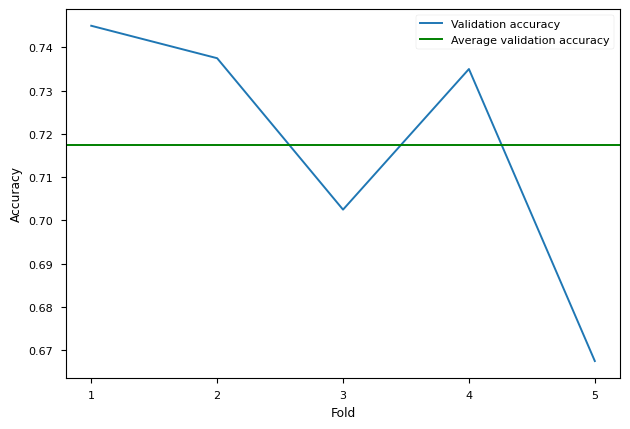

In [31]:
print(f"The average accuracy of model in {k_fold} runs is : {np.mean(model_valid_accuracies):.4f}")

# Plot the validation accuracy for each fold
plt.style.use('seaborn-v0_8-paper')
plt.xticks(range(1, k_fold+1))
plt.plot(np.arange(1, k_fold+1), model_valid_accuracies, label='Validation accuracy')
# Plot the average validation accuracy
plt.axhline(np.mean(model_valid_accuracies), label='Average validation accuracy', c='g')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## Ensemble Learning (Bagging)

### Train ensemble's models

As GPU memory is limited, the trained models are saved to disk and loaded back to the memory when needed.

In [ ]:
# ============== Hyperparameters ==============
ensemble_size = 10
ensemble_checkpoint_path = "/local/home/p11333at/nlp-project/ensemble_checkpoints/"
# ==============================================


#### Training starts here :-)

In [ ]:
skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)

results = []
# Loop for each fold
for fold, (train_idx, valid_idx) in enumerate(skf.split(tokenized_dataset, tokenized_dataset[label_name])):
    print(f"\033[1;37;42m    ==============  {fold+1}/{k_fold} Fold  ==============    \033[0m")

    # Split dataset & Create the DataLoader
    train_dataset = tokenized_dataset.select(train_idx)
    valid_dataset = tokenized_dataset.select(valid_idx)

    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

    metrics_list = []
    predictions_list = []
    for i in range(ensemble_size):
        print(f"\033[1;34;47m    ==========  {i+1}/{ensemble_size} of ensemble  ==========    \033[0m")

        # Initialise bootstrap sample index
        dataset_size = len(train_dataset)
        np.random.seed(42+i)
        bootstrap_index = np.random.choice(dataset_size, dataset_size, replace=True)

        # Retrieve the bootstrap sample
        sample_dataset = train_dataset.select(bootstrap_index)
        sample_dataloader = DataLoader(sample_dataset, batch_size=batch_size)

        print(f"Dataset size: {dataset_size}")
        print(f"Number of distinct data in Bootstrap sample: {len(set(bootstrap_index))}")

        # Instantiate the Model
        model = BertClassifier(model_name, freeze_bert=freeze_bert)
        model.to(device)

        # Define an optimizer to update the parameters
        optimizer = optim.AdamW(
            model.parameters(),
            lr=lr,      # Default learning rate 5e-5
            eps=1e-8    # Default epsilon value 1e-8
        )

        # Define a loss function
        loss_fn = nn.BCEWithLogitsLoss()

        # Instantiate the SentimentAnalyser
        member = SentimentAnalyser(model, loss_fn, optimizer)
        member.set_loaders(sample_dataloader, valid_dataloader)

        # Start training :-)
        member.train(epochs)

        # Evaluation
        metrics = member.evaluate(valid_dataloader)
        metrics_list.append(metrics)

        # Emsemble prediction
        predictions = member.predict(valid_dataloader, return_logits=True)
        predictions_list.append(predictions)

        # Save the model checkpoint
        # member.save_checkpoint(ensemble_checkpoint_path+f"member_{fold+1}_{i+1}.pt")

        # Relsase GPU memory
        del model, optimizer, loss_fn
        del member.model, member.optimizer, member.loss_fn, member.train_loader, member.val_loader, member
        torch.cuda.empty_cache()
    

    # Ensemble prediction
    predictions_list = np.array(predictions_list)
    ensemble_logits = np.mean(predictions_list, axis=0)
    ensemble_predictions = np.argmax(ensemble_logits, axis=1)
    valid_labels = valid_dataset['sentiment.human']

    # Store the results of each fold
    results.append([metrics_list, predictions_list, ensemble_predictions, valid_labels])

    # Relsase GPU memory
    del train_dataset, valid_dataset, sample_dataset, sample_dataloader, valid_dataloader, metrics_list, predictions_list, ensemble_logits, ensemble_predictions, valid_labels
    torch.cuda.empty_cache()

    #######
    # break##
    #######

### Results Visualisation

In [ ]:
# Unpack the results
metrics_list, predictions_list, ensemble_predictions, valid_labels = results[0]
accuracy_list = [metric["val_accuracy"] for metric in metrics_list]

#### Show individule performance

In [ ]:
member_ids = list(range(ensemble_size))
member_losses = [ metr['val_loss'] for metr in metrics_list]
member_accuricies = [ metr['val_accuracy'] for metr in metrics_list]
print(np.mean(member_accuricies))

fig, ax = plt.subplots()
ax.plot(member_ids, member_losses, label="Loss")
ax.plot(member_ids, member_accuricies, label="Accuracy")

# Set the x-axis label, y-axis label, and title
ax.set_xlabel("Model")
ax.set_ylabel("Loss / Accuracy")
ax.set_title("Performance Comparison of Models")

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()

#### Show ensemble performance

In [ ]:
# Plot graph (size_of_ensemble vs ensemble_accuracy)

fig, ax = plt.subplots()

ax.plot(range(ensemble_size), accuracy_list, label="Ensemble Accuracy")
ax.plot(range(ensemble_size), [np.mean(accuracy_list)]*ensemble_size, label="Average Individual Accuracy in Ensemble")
ax.plot(range(ensemble_size), [np.mean(model_valid_accuracies)]*ensemble_size, label="Single Model Accuracy")
# Set the x-axis label, y-axis label, and title
ax.set_xlabel("Number of Models")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs Number of Models")

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()


### `Ensemble` class

The `Ensemble` class contains the functions of applying trained ensemble model to make predictions on new dataset.

In [ ]:
class Ensemble(object):
    def __init__(self, models=None):
        self.models = [] if models is None else models
        self.models_logits_list = []
    
    def __len__(self):
        return len(self.models)

    def add_model(self, model):
        self.models.append(model)

    def predict(self, test_dataloader, return_logits=False):
        all_logits = []
        for model in self.models:
            logits = model.predict(test_dataloader, return_logits=True)
            all_logits.append(logits)
        all_logits = np.array(all_logits)
        # Average logits from each model
        avg_logits = np.mean(all_logits, axis=0)
        if return_logits:
            return avg_logits
        # Apply softmax to calculate probabilities
        probs = F.softmax(torch.tensor(avg_logits), dim=1).numpy()
        return probs

    def calculate_loss(self, logits, lables):
        loss_fn = nn.BCEWithLogitsLoss()
        return loss_fn(logits, lables)    
        
    def load_one_checkpoint_and_predict(self, model, optimizer, checkpoint_file, test_dataloader, save_model_to_memory=False):
        # Instantiate the SentimentAnalyser
        member = SentimentAnalyser(model=model, loss_fn=None, optimizer=optimizer)
        member.load_checkpoint(checkpoint_file)
        logits = member.predict(test_dataloader, return_logits=True)
        self.models_logits_list.append(logits)
        
        if save_model_to_memory:
            self.add_model(member.model)
        else:
            # Relsase GPU memory
            del model, member
            torch.cuda.empty_cache()

        return logits
    
    def combine_logits(self, logits=None):
        logits = logits if logits is not None else self.models_logits_list
        # Average logits from each model
        avg_logits = np.mean(logits, axis=0)
        return avg_logits

### Predictions using `Ensemble` Model

In [ ]:
# ====================== Hyperparameters ======================
# These parameters should be the same as before
set_seed(42)                # Set seed for reproducibility
lr          = lr            # 3e-5
batch_size  = batch_size    # 32
# =============================================================
freeze_bert = freeze_bert   # False
ensemble_checkpoint_path = "/local/home/p11333at/nlp-project/ensemble_checkpoints/"
# =============================================================

ensemble = Ensemble()

# Open all files in the directory
for file in os.listdir(ensemble_checkpoint_path):
    if file.endswith(".pt"):
        print(f"Loading {file} ...")

        # Instantiate the model
        model = BertClassifier(model_name)
        model.to(device)
        optimizer = optim.AdamW(model.parameters(), lr=lr, eps=1e-8)
        test_dataloader = DataLoader(tokenized_dataset, batch_size=batch_size)
        
        # Load the checkpoint and predict
        ensemble.load_one_checkpoint_and_predict(model, optimizer, ensemble_checkpoint_path+file, test_dataloader, save_model_to_memory=True)

# Combine the logits from each model
ensemble_logits = torch.tensor(ensemble.combine_logits()).to(device)
ensemble_predictions = torch.argmax(ensemble_logits, axis=1)
true_logits = torch.tensor(tokenized_dataset["labels"]).to(device)
true_labels = tokenized_dataset["sentiment.openai"]

# Calculate the ensemble performance
print(ensemble.calculate_loss(ensemble_logits, true_logits))
print()
print(classification_report(true_labels, ensemble_predictions.detach().cpu().numpy(), target_names=['Negative', 'Neutral', 'Positive']))

## Experiments

### Experiment Preparation

In [79]:
# ======================== Hyperparameters ========================
set_seed(42)              # Set seed for reproducibility
epochs         = 4        # Recommends 2, 3, 4
lr             = 3e-5     # Recommends 5e-5, 3e-5, 2e-5 (for Adam)
batch_size     = 16       # Recommends 16, 32
# =================================================================
freeze_bert    = False    # Set 'True' if only training the last layer
k_fold         = 5        # Number of folds for Stratified K Fold
ensemble_size  = 10
checkpoint_path = "/local/home/p11333at/nlp-project/checkpoints/"
ensemble_checkpoint_path = "/local/home/p11333at/nlp-project/ensemble_checkpoints/"
# =================================================================

#### Training starts here :-)

The following cell combines:
1. the training of a single model using complete training dataset 
2. and the training of ensemble models using bootstrap sample datasets.

The code is the same as previous cells, but combined together.

In [80]:
import mlnotify
mlnotify.start()

skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)

# Results of single model
model_valid_accuracies = []

# Results of ensemble
results = []

# Loop for each fold
for fold, (train_idx, valid_idx) in enumerate(skf.split(tokenized_dataset, tokenized_dataset[label_name])):
    print(f"\033[1;37;42m    ==============  {fold+1}/{k_fold} Fold  ==============    \033[0m")

    # Split dataset & Create the DataLoader
    train_dataset = tokenized_dataset.select(train_idx)
    valid_dataset = tokenized_dataset.select(valid_idx)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

    # ========================================================================
    # =======================  Train a single model  =========================
    # ========================================================================
    print("\033[1;35;47m    ============  Single model  ============    \033[0m")

    # Instantiate the Model
    model = BertClassifier(model_name, freeze_bert=freeze_bert)
    model.to(device)
    
    # Define an optimizer to update the parameters
    optimizer = optim.AdamW(
        model.parameters(),
        lr=lr,      # Default learning rate 5e-5
        eps=1e-8    # Default epsilon value 1e-8
    )
    # Define a loss function
    loss_fn = nn.BCEWithLogitsLoss()

    # Set up the learning rate scheduler
    num_training_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=num_training_steps)
    
    # Instantiate the SentimentAnalyser
    sa = SentimentAnalyser(model, loss_fn, optimizer)
    sa.set_loaders(train_dataloader, valid_dataloader)
    
    # Start training :-)
    sa.train(epochs)
    
    # Evaluate the model on the validation set & Append the result to the list
    model_valid_accuracies.append(sa.evaluate(valid_dataloader)['val_accuracy'])

    # Save the model checkpoint
    checkpoint_name = f"bert_classifier_{fold+1}.pt"
    sa.save_checkpoint(checkpoint_path+checkpoint_name)

    # Plot the training and validation losses
    # sa.plot_losses()
    
    # Relsase GPU memory
    del model, optimizer, loss_fn, scheduler
    del sa.model, sa.optimizer, sa.loss_fn, sa.train_loader, sa.val_loader, sa
    torch.cuda.empty_cache()
    

    # ========================================================================
    # ========================  Train the Ensemble  ==========================
    # ========================================================================

    metrics_list = []
    predictions_list = []
    for i in range(ensemble_size):
        print(f"\033[1;34;47m    ==========  {i+1}/{ensemble_size} of ensemble  ==========    \033[0m")

        # Initialise bootstrap sample index
        dataset_size = len(train_dataset)
        np.random.seed(42+i)
        bootstrap_index = np.random.choice(dataset_size, dataset_size, replace=True)

        # Retrieve the bootstrap sample
        sample_dataset = train_dataset.select(bootstrap_index)
        sample_dataloader = DataLoader(sample_dataset, batch_size=batch_size)

        print(f"Dataset size: {dataset_size}")
        print(f"Number of distinct data in Bootstrap sample: {len(set(bootstrap_index))}")

        # Instantiate the Model
        model = BertClassifier(model_name, freeze_bert=freeze_bert)
        model.to(device)

        # Define an optimizer to update the parameters
        optimizer = optim.AdamW(
            model.parameters(),
            lr=lr,      # Default learning rate 5e-5
            eps=1e-8    # Default epsilon value 1e-8
        )

        # Define a loss function
        loss_fn = nn.BCEWithLogitsLoss()

        # Instantiate the SentimentAnalyser
        member = SentimentAnalyser(model, loss_fn, optimizer)
        member.set_loaders(sample_dataloader, valid_dataloader)

        # Start training :-)
        member.train(epochs)

        # Evaluation
        metrics = member.evaluate(valid_dataloader)
        metrics_list.append(metrics)

        # Emsemble prediction
        predictions = member.predict(valid_dataloader, return_logits=True)
        predictions_list.append(predictions)

        # Save the model checkpoint
        # member.save_checkpoint(ensemble_checkpoint_path+f"member_{fold+1}_{i+1}.pt")

        # Relsase GPU memory
        del model, optimizer, loss_fn
        del member.model, member.optimizer, member.loss_fn, member.train_loader, member.val_loader, member
        torch.cuda.empty_cache()
    

    # Ensemble prediction
    predictions_list = np.array(predictions_list)
    ensemble_logits = np.mean(predictions_list, axis=0)
    ensemble_predictions = np.argmax(ensemble_logits, axis=1)
    valid_labels = valid_dataset['sentiment.human']

    # Store the results of each fold
    results.append([metrics_list, predictions_list, ensemble_predictions, valid_labels])

    # Relsase GPU memory
    del train_dataset, valid_dataset, sample_dataset, sample_dataloader, valid_dataloader, metrics_list, predictions_list, ensemble_logits, ensemble_predictions, valid_labels
    torch.cuda.empty_cache()

    #######
    # break##
    #######

mlnotify.end()

                                     
                                     
    █▀▀▀▀▀█ █  ▄▄ ▀▀▄ █▄  █▀▀▀▀▀█    
    █ ███ █ ██▄ █▄▀▄▄▀▀▄  █ ███ █    
    █ ▀▀▀ █ ▄██ ▀▀▄▀▀█▀▄▄ █ ▀▀▀ █    
    ▀▀▀▀▀▀▀ ▀ █▄▀ ▀ ▀▄▀▄▀ ▀▀▀▀▀▀▀    
    ██ ▄█▀▀ ▄ ▀ ▀ ▀█▄▀▄▀ ▄▄█▄████    
    ▄ █ ▄▀▀███▀ ▄ ▄█▄▄▄▄█▄█ █▄ ▄█    
    ▀▄██ ▄▀▀▀▄▄▀▄▄▀█▄█▄ ▀▀▄▄▄▄▄█▄    
    ▄▀▄▀  ▀▀▀ ██▀ ▀▀▀▄█  ▀▄▀█▀▀▄█    
    ▄█▄▄██▀▀█▄  ▀▄▀█▄█▄▀ ▀▄▄▄▄ █▄    
       ▀▄ ▀▄█   ▄▀ █▄██ ▀▄▀▀▄ ▀▄█    
    ▀▀    ▀▀▄▄█▀▄▄▀█▄████▀▀▀█▀  █    
    █▀▀▀▀▀█ ▄▀ █▀▀▀█▄▄███ ▀ █▀▀ ▀    
    █ ███ █ ▀█▄ ▀▄▀▄▄▀ █▀█▀▀▀▀  █    
    █ ▀▀▀ █ ▄█  ▄▀▄▀██▀▀█▄   █▀██    
    ▀▀▀▀▀▀▀ ▀▀ ▀▀▀▀ ▀▀ ▀▀▀ ▀ ▀ ▀     
                                     
                                     
https://mlnotify.aporia.com/training/294263

Scan the QR code or enter the url to get a notification when your training is done


    ==============  1/5 Fold  ==============    
    ============  Single model  ============    


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.677363  |   0.460   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.614459   |     -      |     -     |   2.04   
   1    |   40    |   0.588243   |     -      |     -     |   1.96   
   1    |   60    |   0.578645   |     -      |     -     |   1.93   
   1    |   80    |   0.566003   |     -      |     -     |   1.95   
   1    |   100   |   0.554623   |  0.479194  |   0.662   |   10.55  
----------------------------------------------------------------------
   2    |   20    |   0.505821   |     -      |     -     |   2.14   
   2    |   40    |   0.475860   |     -      |     -     |   2.15   
   2    |   60    |   0.460572   |     -      |     -     |   2.16   
   2    |   80    |   0.441084   |     -      |     -     |   2.15   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.694704  |   0.133   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.630885   |     -      |     -     |   2.24   
   1    |   40    |   0.596480   |     -      |     -     |   2.07   
   1    |   60    |   0.578609   |     -      |     -     |   2.05   
   1    |   80    |   0.569524   |     -      |     -     |   2.04   
   1    |   100   |   0.557691   |  0.511626  |   0.578   |   11.11  
----------------------------------------------------------------------
   2    |   20    |   0.464605   |     -      |     -     |   2.07   
   2    |   40    |   0.421100   |     -      |     -     |   2.06   
   2    |   60    |   0.377812   |     -      |     -     |   1.97   
   2    |   80    |   0.364057   |     -      |     -     |   1.96   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713991  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.630245   |     -      |     -     |   2.07   
   1    |   40    |   0.600019   |     -      |     -     |   2.06   
   1    |   60    |   0.578301   |     -      |     -     |   2.05   
   1    |   80    |   0.559138   |     -      |     -     |   2.06   
   1    |   100   |   0.542902   |  0.491702  |   0.625   |   10.93  
----------------------------------------------------------------------
   2    |   20    |   0.407052   |     -      |     -     |   2.04   
   2    |   40    |   0.364952   |     -      |     -     |   2.00   
   2    |   60    |   0.348325   |     -      |     -     |   1.98   
   2    |   80    |   0.326480   |     -      |     -     |   1.98   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713991  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.631691   |     -      |     -     |   2.05   
   1    |   40    |   0.598428   |     -      |     -     |   2.04   
   1    |   60    |   0.576989   |     -      |     -     |   2.00   
   1    |   80    |   0.561475   |     -      |     -     |   2.06   
   1    |   100   |   0.544141   |  0.467856  |   0.675   |   10.83  
----------------------------------------------------------------------
   2    |   20    |   0.426793   |     -      |     -     |   2.03   
   2    |   40    |   0.383068   |     -      |     -     |   2.04   
   2    |   60    |   0.351921   |     -      |     -     |   2.06   
   2    |   80    |   0.323789   |     -      |     -     |   2.06   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713991  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.629049   |     -      |     -     |   2.04   
   1    |   40    |   0.603967   |     -      |     -     |   2.02   
   1    |   60    |   0.578875   |     -      |     -     |   2.01   
   1    |   80    |   0.557738   |     -      |     -     |   2.06   
   1    |   100   |   0.537728   |  0.479682  |   0.637   |   10.81  
----------------------------------------------------------------------
   2    |   20    |   0.402500   |     -      |     -     |   2.06   
   2    |   40    |   0.364680   |     -      |     -     |   1.92   
   2    |   60    |   0.331490   |     -      |     -     |   1.88   
   2    |   80    |   0.313657   |     -      |     -     |   2.02   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713991  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.616257   |     -      |     -     |   2.05   
   1    |   40    |   0.583289   |     -      |     -     |   2.05   
   1    |   60    |   0.574044   |     -      |     -     |   2.02   
   1    |   80    |   0.559148   |     -      |     -     |   2.00   
   1    |   100   |   0.548336   |  0.473525  |   0.655   |   10.68  
----------------------------------------------------------------------
   2    |   20    |   0.447407   |     -      |     -     |   1.96   
   2    |   40    |   0.418669   |     -      |     -     |   1.97   
   2    |   60    |   0.394220   |     -      |     -     |   2.01   
   2    |   80    |   0.361516   |     -      |     -     |   1.93   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713991  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.627273   |     -      |     -     |   2.06   
   1    |   40    |   0.604293   |     -      |     -     |   2.04   
   1    |   60    |   0.583609   |     -      |     -     |   2.03   
   1    |   80    |   0.566616   |     -      |     -     |   1.97   
   1    |   100   |   0.544514   |  0.493603  |   0.637   |   10.65  
----------------------------------------------------------------------
   2    |   20    |   0.410155   |     -      |     -     |   1.97   
   2    |   40    |   0.394429   |     -      |     -     |   2.00   
   2    |   60    |   0.365027   |     -      |     -     |   1.99   
   2    |   80    |   0.338621   |     -      |     -     |   1.95   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713991  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.621251   |     -      |     -     |   1.94   
   1    |   40    |   0.591913   |     -      |     -     |   1.97   
   1    |   60    |   0.579177   |     -      |     -     |   1.97   
   1    |   80    |   0.554756   |     -      |     -     |   1.97   
   1    |   100   |   0.537751   |  0.487297  |   0.630   |   10.44  
----------------------------------------------------------------------
   2    |   20    |   0.412167   |     -      |     -     |   1.95   
   2    |   40    |   0.399626   |     -      |     -     |   1.99   
   2    |   60    |   0.379247   |     -      |     -     |   2.00   
   2    |   80    |   0.350594   |     -      |     -     |   1.99   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713991  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.645790   |     -      |     -     |   2.00   
   1    |   40    |   0.606265   |     -      |     -     |   1.97   
   1    |   60    |   0.582789   |     -      |     -     |   1.99   
   1    |   80    |   0.568675   |     -      |     -     |   1.94   
   1    |   100   |   0.555240   |  0.472811  |   0.680   |   10.55  
----------------------------------------------------------------------
   2    |   20    |   0.447598   |     -      |     -     |   2.12   
   2    |   40    |   0.396998   |     -      |     -     |   2.17   
   2    |   60    |   0.369595   |     -      |     -     |   2.17   
   2    |   80    |   0.345112   |     -      |     -     |   2.16   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713991  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.625335   |     -      |     -     |   2.06   
   1    |   40    |   0.595882   |     -      |     -     |   2.05   
   1    |   60    |   0.584066   |     -      |     -     |   2.06   
   1    |   80    |   0.566474   |     -      |     -     |   2.04   
   1    |   100   |   0.549201   |  0.475249  |   0.657   |   10.89  
----------------------------------------------------------------------
   2    |   20    |   0.439556   |     -      |     -     |   1.93   
   2    |   40    |   0.406777   |     -      |     -     |   1.99   
   2    |   60    |   0.381427   |     -      |     -     |   2.03   
   2    |   80    |   0.358258   |     -      |     -     |   2.01   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713991  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.633671   |     -      |     -     |   2.06   
   1    |   40    |   0.597876   |     -      |     -     |   2.05   
   1    |   60    |   0.580426   |     -      |     -     |   2.06   
   1    |   80    |   0.558285   |     -      |     -     |   2.05   
   1    |   100   |   0.532789   |  0.462373  |   0.690   |   10.89  
----------------------------------------------------------------------
   2    |   20    |   0.415789   |     -      |     -     |   2.04   
   2    |   40    |   0.380411   |     -      |     -     |   2.05   
   2    |   60    |   0.357214   |     -      |     -     |   2.07   
   2    |   80    |   0.330666   |     -      |     -     |   2.04   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.712921  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.636897   |     -      |     -     |   2.07   
   1    |   40    |   0.599573   |     -      |     -     |   2.03   
   1    |   60    |   0.583720   |     -      |     -     |   2.06   
   1    |   80    |   0.571550   |     -      |     -     |   1.97   
   1    |   100   |   0.553301   |  0.474348  |   0.662   |   10.68  
----------------------------------------------------------------------
   2    |   20    |   0.472358   |     -      |     -     |   1.98   
   2    |   40    |   0.459905   |     -      |     -     |   1.96   
   2    |   60    |   0.446734   |     -      |     -     |   2.00   
   2    |   80    |   0.432728   |     -      |     -     |   2.01   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693229  |   0.135   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.619783   |     -      |     -     |   2.00   
   1    |   40    |   0.596459   |     -      |     -     |   2.02   
   1    |   60    |   0.584891   |     -      |     -     |   1.98   
   1    |   80    |   0.580289   |     -      |     -     |   2.01   
   1    |   100   |   0.566965   |  0.530916  |   0.530   |   10.69  
----------------------------------------------------------------------
   2    |   20    |   0.483038   |     -      |     -     |   1.99   
   2    |   40    |   0.468480   |     -      |     -     |   2.01   
   2    |   60    |   0.444957   |     -      |     -     |   2.17   
   2    |   80    |   0.424070   |     -      |     -     |   2.18   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.712921  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.635743   |     -      |     -     |   2.07   
   1    |   40    |   0.608130   |     -      |     -     |   2.05   
   1    |   60    |   0.594511   |     -      |     -     |   2.05   
   1    |   80    |   0.582335   |     -      |     -     |   2.06   
   1    |   100   |   0.570136   |  0.499081  |   0.632   |   10.92  
----------------------------------------------------------------------
   2    |   20    |   0.442918   |     -      |     -     |   2.05   
   2    |   40    |   0.432371   |     -      |     -     |   2.08   
   2    |   60    |   0.405624   |     -      |     -     |   2.12   
   2    |   80    |   0.375018   |     -      |     -     |   2.16   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.712921  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.631189   |     -      |     -     |   2.05   
   1    |   40    |   0.591057   |     -      |     -     |   2.03   
   1    |   60    |   0.575970   |     -      |     -     |   2.05   
   1    |   80    |   0.557027   |     -      |     -     |   2.07   
   1    |   100   |   0.542343   |  0.467522  |   0.660   |   10.89  
----------------------------------------------------------------------
   2    |   20    |   0.392078   |     -      |     -     |   2.05   
   2    |   40    |   0.352893   |     -      |     -     |   2.06   
   2    |   60    |   0.346092   |     -      |     -     |   2.06   
   2    |   80    |   0.327568   |     -      |     -     |   2.06   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.712921  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.628848   |     -      |     -     |   2.04   
   1    |   40    |   0.598764   |     -      |     -     |   2.05   
   1    |   60    |   0.582435   |     -      |     -     |   2.03   
   1    |   80    |   0.568945   |     -      |     -     |   1.99   
   1    |   100   |   0.553935   |  0.481096  |   0.665   |   10.78  
----------------------------------------------------------------------
   2    |   20    |   0.403713   |     -      |     -     |   2.02   
   2    |   40    |   0.395189   |     -      |     -     |   2.05   
   2    |   60    |   0.371740   |     -      |     -     |   2.06   
   2    |   80    |   0.352081   |     -      |     -     |   2.05   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.712921  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.635702   |     -      |     -     |   2.10   
   1    |   40    |   0.600248   |     -      |     -     |   2.12   
   1    |   60    |   0.574674   |     -      |     -     |   2.18   
   1    |   80    |   0.555604   |     -      |     -     |   2.18   
   1    |   100   |   0.537361   |  0.520659  |   0.588   |   11.39  
----------------------------------------------------------------------
   2    |   20    |   0.453740   |     -      |     -     |   2.17   
   2    |   40    |   0.409395   |     -      |     -     |   2.18   
   2    |   60    |   0.383345   |     -      |     -     |   2.18   
   2    |   80    |   0.359113   |     -      |     -     |   2.05   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.712921  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.633852   |     -      |     -     |   2.04   
   1    |   40    |   0.596195   |     -      |     -     |   2.03   
   1    |   60    |   0.580230   |     -      |     -     |   1.90   
   1    |   80    |   0.565478   |     -      |     -     |   1.94   
   1    |   100   |   0.543999   |  0.468361  |   0.650   |   10.51  
----------------------------------------------------------------------
   2    |   20    |   0.409510   |     -      |     -     |   1.91   
   2    |   40    |   0.367648   |     -      |     -     |   1.95   
   2    |   60    |   0.348915   |     -      |     -     |   1.98   
   2    |   80    |   0.327723   |     -      |     -     |   1.90   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.712921  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.643303   |     -      |     -     |   2.08   
   1    |   40    |   0.609811   |     -      |     -     |   2.04   
   1    |   60    |   0.593798   |     -      |     -     |   2.04   
   1    |   80    |   0.576011   |     -      |     -     |   2.04   
   1    |   100   |   0.557334   |  0.478434  |   0.647   |   10.79  
----------------------------------------------------------------------
   2    |   20    |   0.431098   |     -      |     -     |   2.05   
   2    |   40    |   0.419377   |     -      |     -     |   2.05   
   2    |   60    |   0.394098   |     -      |     -     |   2.05   
   2    |   80    |   0.368960   |     -      |     -     |   2.05   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.712921  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.634548   |     -      |     -     |   2.06   
   1    |   40    |   0.601022   |     -      |     -     |   2.03   
   1    |   60    |   0.589593   |     -      |     -     |   2.06   
   1    |   80    |   0.568492   |     -      |     -     |   2.05   
   1    |   100   |   0.547455   |  0.486999  |   0.637   |   10.91  
----------------------------------------------------------------------
   2    |   20    |   0.426164   |     -      |     -     |   2.04   
   2    |   40    |   0.378259   |     -      |     -     |   2.06   
   2    |   60    |   0.354587   |     -      |     -     |   2.04   
   2    |   80    |   0.328649   |     -      |     -     |   2.03   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.712921  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.634660   |     -      |     -     |   2.05   
   1    |   40    |   0.601685   |     -      |     -     |   2.05   
   1    |   60    |   0.581264   |     -      |     -     |   2.04   
   1    |   80    |   0.568365   |     -      |     -     |   2.05   
   1    |   100   |   0.554198   |  0.497189  |   0.637   |   10.94  
----------------------------------------------------------------------
   2    |   20    |   0.443409   |     -      |     -     |   2.12   
   2    |   40    |   0.411052   |     -      |     -     |   2.13   
   2    |   60    |   0.407544   |     -      |     -     |   2.14   
   2    |   80    |   0.384089   |     -      |     -     |   2.15   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.712921  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.629679   |     -      |     -     |   2.09   
   1    |   40    |   0.602313   |     -      |     -     |   2.05   
   1    |   60    |   0.587216   |     -      |     -     |   1.96   
   1    |   80    |   0.573570   |     -      |     -     |   2.01   
   1    |   100   |   0.551062   |  0.485176  |   0.635   |   10.80  
----------------------------------------------------------------------
   2    |   20    |   0.434034   |     -      |     -     |   2.03   
   2    |   40    |   0.412898   |     -      |     -     |   2.05   
   2    |   60    |   0.374708   |     -      |     -     |   2.05   
   2    |   80    |   0.347264   |     -      |     -     |   2.05   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713518  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.631765   |     -      |     -     |   2.04   
   1    |   40    |   0.598977   |     -      |     -     |   1.89   
   1    |   60    |   0.586973   |     -      |     -     |   2.03   
   1    |   80    |   0.571146   |     -      |     -     |   2.06   
   1    |   100   |   0.557906   |  0.475931  |   0.645   |   10.70  
----------------------------------------------------------------------
   2    |   20    |   0.478633   |     -      |     -     |   2.04   
   2    |   40    |   0.462319   |     -      |     -     |   1.90   
   2    |   60    |   0.451018   |     -      |     -     |   1.99   
   2    |   80    |   0.428329   |     -      |     -     |   2.04   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693744  |   0.130   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.619227   |     -      |     -     |   2.09   
   1    |   40    |   0.601476   |     -      |     -     |   2.06   
   1    |   60    |   0.584517   |     -      |     -     |   2.06   
   1    |   80    |   0.568082   |     -      |     -     |   1.95   
   1    |   100   |   0.551093   |  0.506251  |   0.605   |   10.75  
----------------------------------------------------------------------
   2    |   20    |   0.440411   |     -      |     -     |   1.98   
   2    |   40    |   0.442933   |     -      |     -     |   1.96   
   2    |   60    |   0.411269   |     -      |     -     |   2.00   
   2    |   80    |   0.387773   |     -      |     -     |   2.01   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713518  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.633668   |     -      |     -     |   2.08   
   1    |   40    |   0.605214   |     -      |     -     |   2.09   
   1    |   60    |   0.577974   |     -      |     -     |   2.03   
   1    |   80    |   0.559584   |     -      |     -     |   2.08   
   1    |   100   |   0.540776   |  0.484525  |   0.652   |   10.89  
----------------------------------------------------------------------
   2    |   20    |   0.468335   |     -      |     -     |   1.99   
   2    |   40    |   0.435896   |     -      |     -     |   2.06   
   2    |   60    |   0.390941   |     -      |     -     |   1.97   
   2    |   80    |   0.355797   |     -      |     -     |   1.94   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713518  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.629253   |     -      |     -     |   2.07   
   1    |   40    |   0.595998   |     -      |     -     |   2.06   
   1    |   60    |   0.574772   |     -      |     -     |   2.03   
   1    |   80    |   0.556328   |     -      |     -     |   2.02   
   1    |   100   |   0.542363   |  0.478886  |   0.625   |   10.86  
----------------------------------------------------------------------
   2    |   20    |   0.390055   |     -      |     -     |   2.06   
   2    |   40    |   0.357857   |     -      |     -     |   2.07   
   2    |   60    |   0.338490   |     -      |     -     |   2.07   
   2    |   80    |   0.312416   |     -      |     -     |   2.04   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713518  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.626586   |     -      |     -     |   2.06   
   1    |   40    |   0.605665   |     -      |     -     |   2.04   
   1    |   60    |   0.590190   |     -      |     -     |   2.05   
   1    |   80    |   0.572443   |     -      |     -     |   2.06   
   1    |   100   |   0.554890   |  0.477307  |   0.655   |   10.89  
----------------------------------------------------------------------
   2    |   20    |   0.378354   |     -      |     -     |   2.04   
   2    |   40    |   0.375698   |     -      |     -     |   2.06   
   2    |   60    |   0.349175   |     -      |     -     |   2.07   
   2    |   80    |   0.330582   |     -      |     -     |   2.01   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713518  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.621952   |     -      |     -     |   2.17   
   1    |   40    |   0.589618   |     -      |     -     |   2.03   
   1    |   60    |   0.578256   |     -      |     -     |   2.05   
   1    |   80    |   0.563037   |     -      |     -     |   1.93   
   1    |   100   |   0.548889   |  0.479300  |   0.625   |   10.83  
----------------------------------------------------------------------
   2    |   20    |   0.437358   |     -      |     -     |   2.04   
   2    |   40    |   0.403424   |     -      |     -     |   2.07   
   2    |   60    |   0.379446   |     -      |     -     |   2.04   
   2    |   80    |   0.355290   |     -      |     -     |   2.02   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713518  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.631293   |     -      |     -     |   2.16   
   1    |   40    |   0.597266   |     -      |     -     |   2.12   
   1    |   60    |   0.581566   |     -      |     -     |   2.11   
   1    |   80    |   0.569296   |     -      |     -     |   2.13   
   1    |   100   |   0.554331   |  0.474615  |   0.660   |   11.35  
----------------------------------------------------------------------
   2    |   20    |   0.452646   |     -      |     -     |   2.13   
   2    |   40    |   0.398040   |     -      |     -     |   2.13   
   2    |   60    |   0.382949   |     -      |     -     |   2.02   
   2    |   80    |   0.356519   |     -      |     -     |   2.09   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713518  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.640581   |     -      |     -     |   2.21   
   1    |   40    |   0.597602   |     -      |     -     |   2.16   
   1    |   60    |   0.583442   |     -      |     -     |   2.18   
   1    |   80    |   0.561954   |     -      |     -     |   2.19   
   1    |   100   |   0.555227   |  0.482165  |   0.645   |   11.63  
----------------------------------------------------------------------
   2    |   20    |   0.437318   |     -      |     -     |   2.27   
   2    |   40    |   0.407337   |     -      |     -     |   2.18   
   2    |   60    |   0.379722   |     -      |     -     |   2.30   
   2    |   80    |   0.355136   |     -      |     -     |   2.21   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713518  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.628202   |     -      |     -     |   1.94   
   1    |   40    |   0.599692   |     -      |     -     |   2.06   
   1    |   60    |   0.585052   |     -      |     -     |   2.15   
   1    |   80    |   0.568380   |     -      |     -     |   2.15   
   1    |   100   |   0.544273   |  0.463064  |   0.667   |   11.07  
----------------------------------------------------------------------
   2    |   20    |   0.448203   |     -      |     -     |   2.13   
   2    |   40    |   0.414727   |     -      |     -     |   2.15   
   2    |   60    |   0.381685   |     -      |     -     |   2.15   
   2    |   80    |   0.353616   |     -      |     -     |   2.14   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713518  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.622671   |     -      |     -     |   2.04   
   1    |   40    |   0.586012   |     -      |     -     |   2.02   
   1    |   60    |   0.574111   |     -      |     -     |   2.02   
   1    |   80    |   0.558879   |     -      |     -     |   2.05   
   1    |   100   |   0.540428   |  0.483494  |   0.645   |   10.80  
----------------------------------------------------------------------
   2    |   20    |   0.408046   |     -      |     -     |   2.02   
   2    |   40    |   0.376183   |     -      |     -     |   2.10   
   2    |   60    |   0.360603   |     -      |     -     |   2.15   
   2    |   80    |   0.331399   |     -      |     -     |   2.13   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713518  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.641722   |     -      |     -     |   2.08   
   1    |   40    |   0.603549   |     -      |     -     |   2.08   
   1    |   60    |   0.581370   |     -      |     -     |   2.06   
   1    |   80    |   0.571198   |     -      |     -     |   2.07   
   1    |   100   |   0.549287   |  0.467117  |   0.662   |   10.97  
----------------------------------------------------------------------
   2    |   20    |   0.385515   |     -      |     -     |   2.06   
   2    |   40    |   0.361257   |     -      |     -     |   2.07   
   2    |   60    |   0.338465   |     -      |     -     |   2.01   
   2    |   80    |   0.317302   |     -      |     -     |   2.03   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713175  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.641594   |     -      |     -     |   2.05   
   1    |   40    |   0.601357   |     -      |     -     |   2.03   
   1    |   60    |   0.584378   |     -      |     -     |   2.05   
   1    |   80    |   0.574872   |     -      |     -     |   2.04   
   1    |   100   |   0.558079   |  0.471863  |   0.667   |   10.84  
----------------------------------------------------------------------
   2    |   20    |   0.478747   |     -      |     -     |   2.03   
   2    |   40    |   0.453659   |     -      |     -     |   2.03   
   2    |   60    |   0.443382   |     -      |     -     |   2.04   
   2    |   80    |   0.428655   |     -      |     -     |   2.03   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693916  |   0.147   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.623470   |     -      |     -     |   2.05   
   1    |   40    |   0.593777   |     -      |     -     |   1.97   
   1    |   60    |   0.578686   |     -      |     -     |   2.02   
   1    |   80    |   0.564986   |     -      |     -     |   2.03   
   1    |   100   |   0.555449   |  0.521689  |   0.593   |   10.74  
----------------------------------------------------------------------
   2    |   20    |   0.481654   |     -      |     -     |   2.03   
   2    |   40    |   0.434907   |     -      |     -     |   2.05   
   2    |   60    |   0.413635   |     -      |     -     |   2.04   
   2    |   80    |   0.386668   |     -      |     -     |   2.04   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713175  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.619132   |     -      |     -     |   2.03   
   1    |   40    |   0.596207   |     -      |     -     |   2.04   
   1    |   60    |   0.578666   |     -      |     -     |   2.03   
   1    |   80    |   0.562237   |     -      |     -     |   2.06   
   1    |   100   |   0.545051   |  0.482350  |   0.645   |   10.88  
----------------------------------------------------------------------
   2    |   20    |   0.432530   |     -      |     -     |   2.07   
   2    |   40    |   0.401507   |     -      |     -     |   2.13   
   2    |   60    |   0.377029   |     -      |     -     |   2.13   
   2    |   80    |   0.347471   |     -      |     -     |   2.14   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713175  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.633386   |     -      |     -     |   2.20   
   1    |   40    |   0.603053   |     -      |     -     |   2.16   
   1    |   60    |   0.582852   |     -      |     -     |   2.14   
   1    |   80    |   0.563203   |     -      |     -     |   2.15   
   1    |   100   |   0.540790   |  0.484822  |   0.640   |   11.44  
----------------------------------------------------------------------
   2    |   20    |   0.407995   |     -      |     -     |   2.14   
   2    |   40    |   0.391124   |     -      |     -     |   2.15   
   2    |   60    |   0.360233   |     -      |     -     |   2.15   
   2    |   80    |   0.336703   |     -      |     -     |   2.15   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713175  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.624436   |     -      |     -     |   2.12   
   1    |   40    |   0.591437   |     -      |     -     |   2.02   
   1    |   60    |   0.571351   |     -      |     -     |   2.03   
   1    |   80    |   0.559875   |     -      |     -     |   2.03   
   1    |   100   |   0.544343   |  0.493123  |   0.637   |   10.85  
----------------------------------------------------------------------
   2    |   20    |   0.422957   |     -      |     -     |   2.02   
   2    |   40    |   0.389705   |     -      |     -     |   2.03   
   2    |   60    |   0.365418   |     -      |     -     |   2.02   
   2    |   80    |   0.344507   |     -      |     -     |   2.03   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713175  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.610974   |     -      |     -     |   2.21   
   1    |   40    |   0.589533   |     -      |     -     |   2.17   
   1    |   60    |   0.575818   |     -      |     -     |   2.18   
   1    |   80    |   0.561758   |     -      |     -     |   2.18   
   1    |   100   |   0.542663   |  0.469596  |   0.652   |   11.57  
----------------------------------------------------------------------
   2    |   20    |   0.400703   |     -      |     -     |   2.16   
   2    |   40    |   0.377874   |     -      |     -     |   2.19   
   2    |   60    |   0.352355   |     -      |     -     |   2.13   
   2    |   80    |   0.336936   |     -      |     -     |   2.06   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713175  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.634364   |     -      |     -     |   2.16   
   1    |   40    |   0.597720   |     -      |     -     |   2.14   
   1    |   60    |   0.589203   |     -      |     -     |   2.14   
   1    |   80    |   0.569487   |     -      |     -     |   2.13   
   1    |   100   |   0.550463   |  0.484647  |   0.645   |   11.38  
----------------------------------------------------------------------
   2    |   20    |   0.422191   |     -      |     -     |   2.13   
   2    |   40    |   0.391017   |     -      |     -     |   2.14   
   2    |   60    |   0.369490   |     -      |     -     |   2.14   
   2    |   80    |   0.340458   |     -      |     -     |   2.14   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713175  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.633433   |     -      |     -     |   2.08   
   1    |   40    |   0.599883   |     -      |     -     |   2.07   
   1    |   60    |   0.580914   |     -      |     -     |   2.06   
   1    |   80    |   0.564313   |     -      |     -     |   2.03   
   1    |   100   |   0.544466   |  0.503495  |   0.593   |   10.90  
----------------------------------------------------------------------
   2    |   20    |   0.425968   |     -      |     -     |   2.02   
   2    |   40    |   0.409359   |     -      |     -     |   2.03   
   2    |   60    |   0.381364   |     -      |     -     |   2.03   
   2    |   80    |   0.348021   |     -      |     -     |   2.03   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713175  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.622608   |     -      |     -     |   2.01   
   1    |   40    |   0.587037   |     -      |     -     |   2.02   
   1    |   60    |   0.571351   |     -      |     -     |   2.03   
   1    |   80    |   0.555402   |     -      |     -     |   2.02   
   1    |   100   |   0.537836   |  0.542907  |   0.583   |   10.72  
----------------------------------------------------------------------
   2    |   20    |   0.414826   |     -      |     -     |   2.04   
   2    |   40    |   0.381357   |     -      |     -     |   2.04   
   2    |   60    |   0.363876   |     -      |     -     |   2.03   
   2    |   80    |   0.338936   |     -      |     -     |   2.03   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713175  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.632557   |     -      |     -     |   2.06   
   1    |   40    |   0.597646   |     -      |     -     |   2.05   
   1    |   60    |   0.586720   |     -      |     -     |   2.04   
   1    |   80    |   0.564209   |     -      |     -     |   2.03   
   1    |   100   |   0.549275   |  0.506401  |   0.595   |   10.85  
----------------------------------------------------------------------
   2    |   20    |   0.421775   |     -      |     -     |   2.02   
   2    |   40    |   0.393107   |     -      |     -     |   2.04   
   2    |   60    |   0.388142   |     -      |     -     |   2.03   
   2    |   80    |   0.355730   |     -      |     -     |   2.03   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713175  |   0.142   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.630573   |     -      |     -     |   1.58   
   1    |   40    |   0.600640   |     -      |     -     |   1.57   
   1    |   60    |   0.584986   |     -      |     -     |   1.57   
   1    |   80    |   0.569068   |     -      |     -     |   1.58   
   1    |   100   |   0.551081   |  0.490336  |   0.645   |   8.48   
----------------------------------------------------------------------
   2    |   20    |   0.448394   |     -      |     -     |   1.59   
   2    |   40    |   0.418058   |     -      |     -     |   1.57   
   2    |   60    |   0.398218   |     -      |     -     |   1.59   
   2    |   80    |   0.370853   |     -      |     -     |   1.59   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713711  |   0.145   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.640938   |     -      |     -     |   2.07   
   1    |   40    |   0.606403   |     -      |     -     |   2.03   
   1    |   60    |   0.583965   |     -      |     -     |   2.06   
   1    |   80    |   0.573722   |     -      |     -     |   2.04   
   1    |   100   |   0.561201   |  0.491889  |   0.635   |   10.88  
----------------------------------------------------------------------
   2    |   20    |   0.508478   |     -      |     -     |   2.03   
   2    |   40    |   0.478497   |     -      |     -     |   2.01   
   2    |   60    |   0.450456   |     -      |     -     |   1.94   
   2    |   80    |   0.438741   |     -      |     -     |   2.02   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.693494  |   0.135   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.624057   |     -      |     -     |   2.02   
   1    |   40    |   0.593813   |     -      |     -     |   2.04   
   1    |   60    |   0.579831   |     -      |     -     |   2.03   
   1    |   80    |   0.566059   |     -      |     -     |   2.04   
   1    |   100   |   0.545805   |  0.533995  |   0.562   |   10.81  
----------------------------------------------------------------------
   2    |   20    |   0.449545   |     -      |     -     |   2.02   
   2    |   40    |   0.415928   |     -      |     -     |   2.03   
   2    |   60    |   0.380791   |     -      |     -     |   2.04   
   2    |   80    |   0.351718   |     -      |     -     |   2.03   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713711  |   0.145   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.621873   |     -      |     -     |   1.99   
   1    |   40    |   0.595041   |     -      |     -     |   2.03   
   1    |   60    |   0.578620   |     -      |     -     |   2.05   
   1    |   80    |   0.564462   |     -      |     -     |   2.03   
   1    |   100   |   0.547767   |  0.488848  |   0.650   |   10.77  
----------------------------------------------------------------------
   2    |   20    |   0.422990   |     -      |     -     |   2.02   
   2    |   40    |   0.400770   |     -      |     -     |   2.04   
   2    |   60    |   0.374181   |     -      |     -     |   2.04   
   2    |   80    |   0.349815   |     -      |     -     |   2.49   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713711  |   0.145   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.627853   |     -      |     -     |   2.05   
   1    |   40    |   0.596596   |     -      |     -     |   2.03   
   1    |   60    |   0.581784   |     -      |     -     |   2.03   
   1    |   80    |   0.561531   |     -      |     -     |   2.03   
   1    |   100   |   0.542615   |  0.517710  |   0.568   |   10.78  
----------------------------------------------------------------------
   2    |   20    |   0.461036   |     -      |     -     |   2.03   
   2    |   40    |   0.417997   |     -      |     -     |   2.03   
   2    |   60    |   0.395393   |     -      |     -     |   2.03   
   2    |   80    |   0.362395   |     -      |     -     |   2.02   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713711  |   0.145   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.624849   |     -      |     -     |   2.07   
   1    |   40    |   0.589299   |     -      |     -     |   2.03   
   1    |   60    |   0.576385   |     -      |     -     |   2.07   
   1    |   80    |   0.559257   |     -      |     -     |   2.13   
   1    |   100   |   0.537927   |  0.488452  |   0.618   |   11.16  
----------------------------------------------------------------------
   2    |   20    |   0.437572   |     -      |     -     |   2.13   
   2    |   40    |   0.406295   |     -      |     -     |   2.14   
   2    |   60    |   0.372725   |     -      |     -     |   2.13   
   2    |   80    |   0.342710   |     -      |     -     |   2.03   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713711  |   0.145   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.608896   |     -      |     -     |   1.60   
   1    |   40    |   0.589193   |     -      |     -     |   1.56   
   1    |   60    |   0.569818   |     -      |     -     |   1.56   
   1    |   80    |   0.557918   |     -      |     -     |   1.58   
   1    |   100   |   0.539459   |  0.487092  |   0.637   |   8.48   
----------------------------------------------------------------------
   2    |   20    |   0.387893   |     -      |     -     |   1.57   
   2    |   40    |   0.381423   |     -      |     -     |   1.56   
   2    |   60    |   0.354337   |     -      |     -     |   1.56   
   2    |   80    |   0.338098   |     -      |     -     |   1.59   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713711  |   0.145   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.613754   |     -      |     -     |   2.07   
   1    |   40    |   0.595622   |     -      |     -     |   2.08   
   1    |   60    |   0.580141   |     -      |     -     |   2.06   
   1    |   80    |   0.563697   |     -      |     -     |   2.07   
   1    |   100   |   0.544070   |  0.482898  |   0.655   |   11.00  
----------------------------------------------------------------------
   2    |   20    |   0.382972   |     -      |     -     |   2.02   
   2    |   40    |   0.373576   |     -      |     -     |   1.97   
   2    |   60    |   0.350788   |     -      |     -     |   2.01   
   2    |   80    |   0.330819   |     -      |     -     |   2.03   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713711  |   0.145   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.629931   |     -      |     -     |   2.09   
   1    |   40    |   0.599918   |     -      |     -     |   2.00   
   1    |   60    |   0.587587   |     -      |     -     |   1.97   
   1    |   80    |   0.573107   |     -      |     -     |   2.02   
   1    |   100   |   0.552156   |  0.485864  |   0.637   |   10.81  
----------------------------------------------------------------------
   2    |   20    |   0.431101   |     -      |     -     |   2.02   
   2    |   40    |   0.405748   |     -      |     -     |   2.04   
   2    |   60    |   0.384792   |     -      |     -     |   2.04   
   2    |   80    |   0.356209   |     -      |     -     |   2.04   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713711  |   0.145   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.637433   |     -      |     -     |   2.07   
   1    |   40    |   0.598045   |     -      |     -     |   2.08   
   1    |   60    |   0.579541   |     -      |     -     |   1.98   
   1    |   80    |   0.562567   |     -      |     -     |   2.04   
   1    |   100   |   0.545968   |  0.500521  |   0.630   |   10.84  
----------------------------------------------------------------------
   2    |   20    |   0.406000   |     -      |     -     |   2.03   
   2    |   40    |   0.378619   |     -      |     -     |   2.04   
   2    |   60    |   0.350230   |     -      |     -     |   2.04   
   2    |   80    |   0.323335   |     -      |     -     |   2.04   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713711  |   0.145   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.621511   |     -      |     -     |   2.07   
   1    |   40    |   0.596782   |     -      |     -     |   2.03   
   1    |   60    |   0.575870   |     -      |     -     |   2.03   
   1    |   80    |   0.564131   |     -      |     -     |   2.03   
   1    |   100   |   0.550691   |  0.508533  |   0.630   |   10.83  
----------------------------------------------------------------------
   2    |   20    |   0.413738   |     -      |     -     |   1.98   
   2    |   40    |   0.399606   |     -      |     -     |   1.97   
   2    |   60    |   0.382020   |     -      |     -     |   2.03   
   2    |   80    |   0.356860   |     -      |     -     |   2.03   
   2    |   100  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   0    |    -    |      -       |  0.713711  |   0.145   |     -    
----------------------------------------------------------------------
   1    |   20    |   0.622219   |     -      |     -     |   2.10   
   1    |   40    |   0.599228   |     -      |     -     |   2.13   
   1    |   60    |   0.584622   |     -      |     -     |   2.14   
   1    |   80    |   0.571489   |     -      |     -     |   2.14   
   1    |   100   |   0.557899   |  0.521984  |   0.583   |   11.38  
----------------------------------------------------------------------
   2    |   20    |   0.403991   |     -      |     -     |   2.14   
   2    |   40    |   0.386401   |     -      |     -     |   2.14   
   2    |   60    |   0.378790   |     -      |     -     |   2.15   
   2    |   80    |   0.356915   |     -      |     -     |   2.15   
   2    |   100  

### Experiment 1: Compare the performance of single model and ensemble model

              precision    recall  f1-score   support

    Negative       0.77      0.89      0.82       194
     Netural       0.69      0.58      0.63        57
    Positive       0.79      0.68      0.73       149

    accuracy                           0.77       400
   macro avg       0.75      0.71      0.73       400
weighted avg       0.76      0.77      0.76       400

              precision    recall  f1-score   support

    Negative       0.75      0.83      0.79       194
     Netural       0.76      0.44      0.56        57
    Positive       0.68      0.68      0.68       149

    accuracy                           0.72       400
   macro avg       0.73      0.65      0.67       400
weighted avg       0.72      0.72      0.71       400

              precision    recall  f1-score   support

    Negative       0.80      0.84      0.82       195
     Netural       0.70      0.65      0.67        57
    Positive       0.71      0.69      0.70       148

    accuracy        

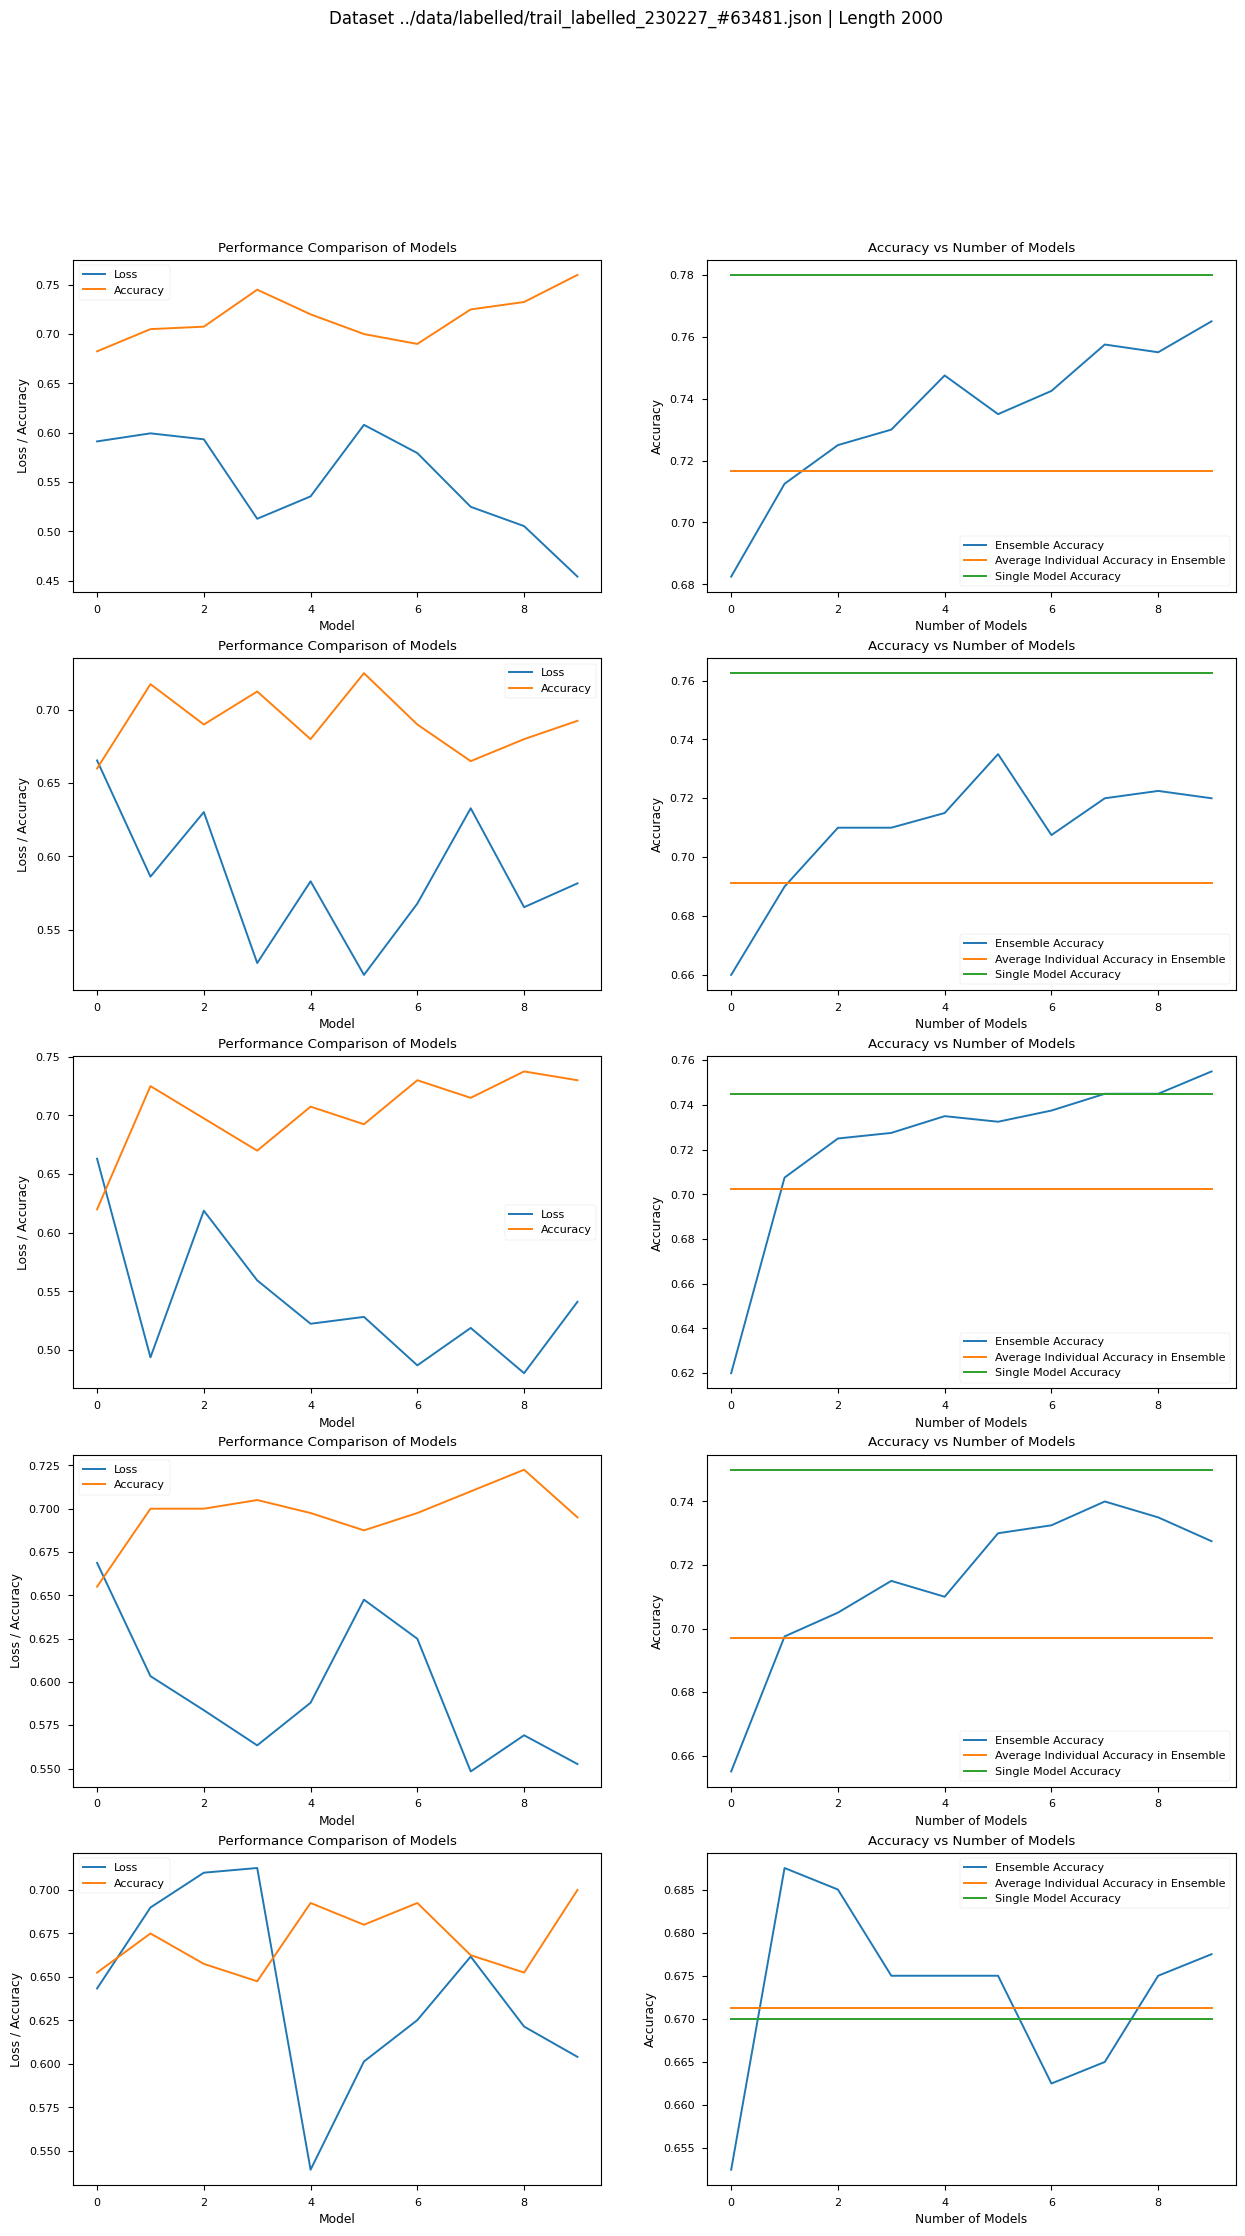

In [81]:
num = len(model_valid_accuracies)

fig, ax = plt.subplots(num, 2, figsize=(15, 5*num))
fig.suptitle(f'Dataset {dataset_path} | Length {len(dataset)}')

for n in range(num):
    # Retrieve the accuracy of single model
    single_model_accuracy = model_valid_accuracies[n]
    # Unpack the results of emsemble
    # metrics_list, logits_list, ensemble_predictions, valid_labels = results[n]
    metrics_list, logits_list, _ , valid_labels = results[n]
    accuracy_list = [metric["val_accuracy"] for metric in metrics_list]     # Accuracy of each member in current fold

    ensemble_logits = [ np.mean(logits_list[:i+1], axis=0) for i in range(len(logits_list)) ]
    ensemble_predictions = np.argmax(ensemble_logits, axis=-1)
    ensemble_accuracy = [accuracy_score(valid_labels, pred) for pred in ensemble_predictions]
    

    # --------------------------------------------------
    # Plot the loss and accuracy of each member in the ensemble
    member_ids = list(range(ensemble_size))
    member_losses = [ metr['val_loss'] for metr in metrics_list]
    member_accuricies = [ metr['val_accuracy'] for metr in metrics_list]

    ax[n, 0].plot(member_ids, member_losses, label="Loss")
    ax[n, 0].plot(member_ids, member_accuricies, label="Accuracy")

    # Set the x-axis label, y-axis label, and title
    ax[n, 0].set_xlabel("Model")
    ax[n, 0].set_ylabel("Loss / Accuracy")
    ax[n, 0].set_title("Performance Comparison of Models")

    # Add a legend to the plot
    ax[n, 0].legend()

    # Show the plot
    # plt.show()

    # --------------------------------------------------
    # Plot graph (size_of_ensemble vs ensemble_accuracy)

    ax[n, 1].plot(range(ensemble_size), ensemble_accuracy, label="Ensemble Accuracy")
    # ax[n, 1].plot(range(ensemble_size), accuracy_list, label="Individual Accuracy of each Model in Ensemble")
    ax[n, 1].plot(range(ensemble_size), [np.mean(accuracy_list)]*ensemble_size, label="Average Individual Accuracy in Ensemble")
    ax[n, 1].plot(range(ensemble_size), [single_model_accuracy]*ensemble_size, label="Single Model Accuracy")
    # Set the x-axis label, y-axis label, and title
    ax[n, 1].set_xlabel("Number of Models")
    ax[n, 1].set_ylabel("Accuracy")
    ax[n, 1].set_title("Accuracy vs Number of Models")

    # Add a legend to the plot
    ax[n, 1].legend()

    # Show the plot
    # plt.show()
    # img_path = "../asset/image/"
    # plt.savefig(img_path + f'ensemble_comparison_{n}.png')

    print(classification_report(valid_labels, ensemble_predictions[-1], target_names=['Negative', 'Netural', 'Positive']))


img_path = "../asset/image/"
plt.savefig(img_path + f'ensemble_comparison.png')

THE END